In [1]:
%load_ext autoreload
%autoreload 2

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import pickle
import scanpy as sc
import scipy
import seaborn as sns
from sklearn import decomposition
import time
import warnings
import umap
import tensorflow

import tcellmatch.api as tm

base_dir = '.'

grid_search_dir = base_dir+'grid_searches'
datadir = base_dir+'raw_data'
outdir = base_dir+'results'
figir = base_dir+'panels/'

sc.logging.print_version_and_date()
sc.settings.verbosity = 3

warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

/Users/david.fischer/opt/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Running Scanpy 1.4.6, on 2020-06-29 18:29.


In [2]:
import matplotlib.pylab as pylab
params = {
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}
pylab.rcParams.update(params)

This notebook loads output files from grid searches and assembles all model benchmarking panels that are shown in the manuscript.

This notebook creates the panels:
    - Fig. 1 c,d,e,f,g
    - Fig. 2 a,b,c
    - Fig. 3 c,d,e
    - Supp. Fig. 1a,b
    - Supp. Fig. 4a,b,c
    - Supp. Fig. 5a,b,c

# Utils

## Loading functions

## Utils

In [3]:
def sort_antigens_by_similarity(
    query_antigens,
    reference_antigens
):
    # Compute pairwise manhatten distances.
    distmat = np.zeros([len(query_antigens), len(reference_antigens)])
    for i, x in enumerate(query_antigens):
        for j, y in enumerate(reference_antigens):
            dist_ij = 0
            for k, z in enumerate(x):
                if len(y) > k:
                    if z != y[k]:
                        dist_ij +=1
                else:
                    dist_ij +=1
            if len(y) > len(x):
                dist_ij = dist_ij + len(y) - len(x)
            distmat[i, j] = dist_ij
    # Return sorted queries by shortest distance to any reference.
    mindist = np.asarray(np.amin(distmat, axis=1), dtype=int)
    return dict(list(zip(query_antigens, mindist)))

Covariate keys:
    - S1: no covariates
    - S2: donor covariate
    - S3: donor covariate + total counts covariate
    - S4: donor covariate + total counts covariate + surface protein expression (cell type information)
    - S5: total counts covariate only
    - S6: negative control counts
    - S7: donor + negative control counts
    - S8: donor + negative control counts + total counts covariate + surface protein expression (cell type information)

# Fig. 1 

## Fig. 1c

In [4]:
container_1c = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's1_bigru_cce_1x1',
        's1_linear_cce_1x1',
        's2_bigru_cce_1x1',
        's2_linear_cce_1x1',
        's3_bigru_cce_1x1',
        's3_linear_cce_1x1',
        's4_bigru_cce_1x1',
        's4_linear_cce_1x1',
        's5_bigru_cce_1x1',
        's5_linear_cce_1x1',
        's6_bigru_cce_1x1',
        's6_linear_cce_1x1',
        's7_bigru_cce_1x1',
        's7_linear_cce_1x1',
        's8_bigru_cce_1x1',
        's8_linear_cce_1x1'
    ]
)
container_1c.load_all()

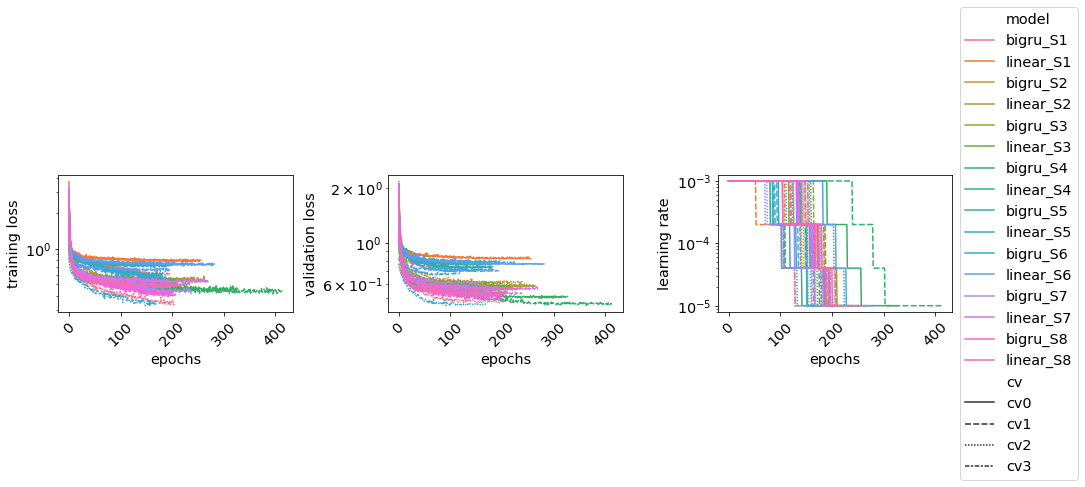

In [5]:
ids = container_1c.choose_best(
    partition="val",
    metric="keras_ce",
    groups_keep=["model", "covariate_key"]
)["run"]
container_1c.plot_training_overview(ids=ids)
plt.tight_layout()

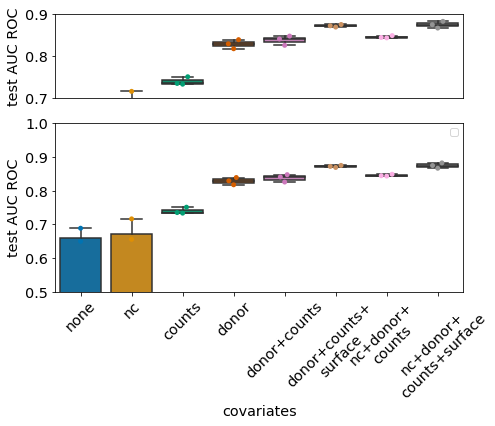

In [6]:
sns.set_palette("colorblind")
fig, axs = container_1c.plot_metrics_topmodel(
    x="covariate_key",
    hue=None,
    select_metric="keras_ce",
    select_partition="val",
    show_partition="test",
    subset=[["chain_key", "CONCAT"], ["model", "bigru"]],
    rename_levels=[
        ["covariate_key", "S1", "none"],
        ["covariate_key", "S6", "nc"],
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+\ncounts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"]
    ],
    plot_roc_only=True,
    ylim=[0.7, 0.9],
    xrot=45,
    show_swarm=True
)
axs[1].set_xlabel("covariates")
plt.tight_layout()
plt.savefig(figir+'main_1_c.pdf')
plt.show()

## Fig. 1d

In [7]:
results_tab_1d = container_1c.load_table()
results_tab_1d = container_1c.reduce_table(
    tab=results_tab_1d,
    metric="keras_ce",
    partition="val",
    groups_keep=["covariate_key", "chain_key"],
)
results_tab_1d = container_1c.rename_levels(
    tab=results_tab_1d,
    rename_levels=[
        ["covariate_key", "S1", "none"],
        ["covariate_key", "S6", "nc"],
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+\ncounts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"]
    ]
)

In [8]:
hue = "covariate_key"
model_baseline = ["s8_bigru_cce_1x1", "nc+donor+\ncounts+surface"]
models_ref = [
    ["s5_bigru_cce_1x1", "counts"],
    ["s2_bigru_cce_1x1", "donor"],
    ["s3_bigru_cce_1x1", "donor+counts"],
    ["s4_bigru_cce_1x1", "donor+counts+\nsurface"],
    ["s7_bigru_cce_1x1", "nc+donor+\ncounts"]
]
confusion_mat = np.zeros([len(models_ref), 3, 2, 2])
for i, cv in enumerate(["0", "1", "2"]):
    run0 = results_tab_1d["run"].values[np.logical_and(
        results_tab_1d[hue].values == model_baseline[1],
        results_tab_1d["cv"].values == cv,
    )][0]
    yhat0 = np.load(
        grid_search_dir+"/10x_cd8/"+model_baseline[0]+'/models/'+run0+"_yhat_test.npy"
    )
    yobs0 = scipy.sparse.load_npz(
        grid_search_dir+"/10x_cd8/"+model_baseline[0]+'/models/'+run0+"_y_test.npz"
    )
    for j, ref in enumerate(models_ref):
        run1 = results_tab_1d["run"].values[np.logical_and(
            results_tab_1d[hue].values == ref[1],
            results_tab_1d["cv"].values == cv,
        )][0]
        yhat1 = np.load(
            grid_search_dir+"/10x_cd8/"+ref[0]+'/models/'+run1+"_yhat_test.npy"
        )
        yobs1 = scipy.sparse.load_npz(
            grid_search_dir+"/10x_cd8/"+ref[0]+'/models/'+run1+"_y_test.npz"
        )
        assert not (yobs0 != yobs1).toarray().any()
        confusion_mat[j, i, 0, 0] = np.mean(np.logical_and(
            np.argmax(yhat0, axis=1).flatten() == np.argmax(yobs0, axis=1).flatten(),
            np.argmax(yhat1, axis=1).flatten() == np.argmax(yobs1, axis=1).flatten()
        ))
        confusion_mat[j, i, 1, 0] = np.mean(np.logical_and(
            np.argmax(yhat0, axis=1).flatten() != np.argmax(yobs0, axis=1).flatten(),
            np.argmax(yhat1, axis=1).flatten() == np.argmax(yobs1, axis=1).flatten()
        ))
        confusion_mat[j, i, 0, 1] = np.mean(np.logical_and(
            np.argmax(yhat0, axis=1).flatten() == np.argmax(yobs0, axis=1).flatten(),
            np.argmax(yhat1, axis=1).flatten() != np.argmax(yobs1, axis=1).flatten()
        ))
        confusion_mat[j, i, 1, 1] = np.mean(np.logical_and(
            np.argmax(yhat0, axis=1).flatten() != np.argmax(yobs0, axis=1).flatten(),
            np.argmax(yhat1, axis=1).flatten() != np.argmax(yobs1, axis=1).flatten()
        ))

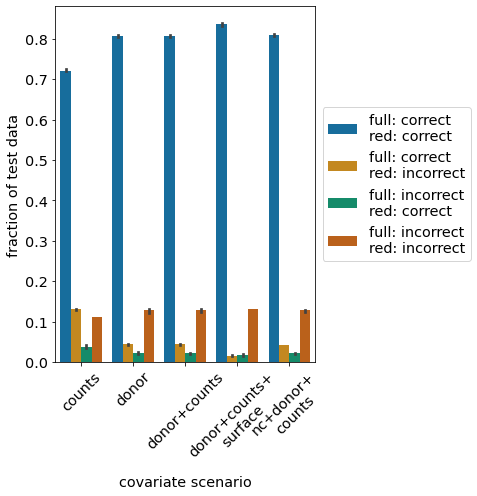

In [9]:
sns.set_palette("colorblind")
sns_data_confusion = pandas.concat([
    pandas.concat([pandas.DataFrame({
        "pie": [
            "full: correct\nred: correct",
            "full: correct\nred: incorrect",
            "full: incorrect\nred: correct",
            "full: incorrect\nred: incorrect"
        ],
        "value": confusion_mat[i, j].flatten(),
        "cv": str(j),
        "model": models_ref[i][1]
    }) for  j in range(confusion_mat.shape[1])])
 for  i in range(confusion_mat.shape[0])])
temp = sns_data_confusion["model"].values
#temp[temp == "donor+counts+surface"] = "donor+counts+\nsurface"
#temp[temp == "nc+donor+counts"] = "nc+donor+\ncounts"
sns_data_confusion["model"] = temp

fig, axs = plt.subplots(1, 1, figsize=(7, 7))
sns.set_palette("colorblind")
sns.barplot(
    data=sns_data_confusion,
    x="model",
    hue="pie",
    y="value",
    ax=axs
)   
axs.tick_params(axis='x', labelrotation=45)
axs.set_xlabel("covariate scenario")
axs.set_ylabel("fraction of test data")
plt.tight_layout()
box = axs.get_position()
axs.set_position([box.x0, box.y0, box.width * 0.6, box.height])
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(figir+'main_1_d.pdf')

## Fig. 1e

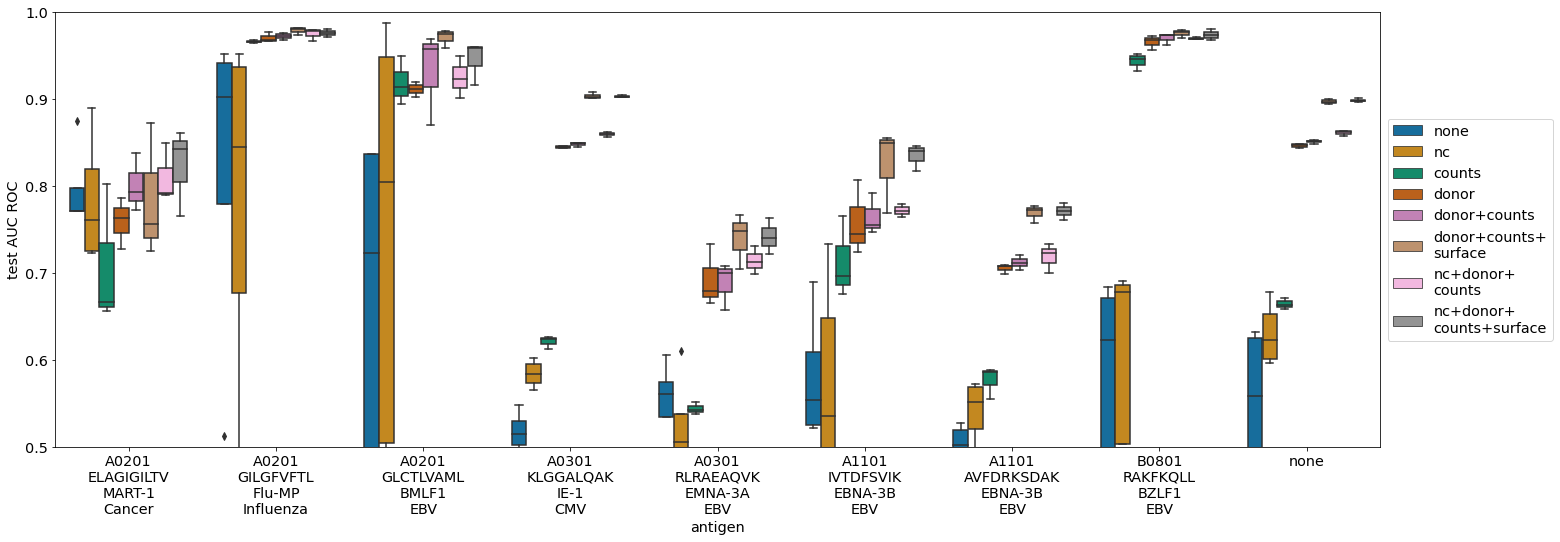

In [10]:
sns.set_palette("colorblind")
fig, axs = container_1c.plot_metrics_topmodel_split(
    hue="covariate_key",
    select_metric="keras_ce",
    select_partition="val",
    show_partition="test",
    subset=[["chain_key", "CONCAT"], ["model", "bigru"]],
    rename_levels=[
        ["covariate_key", "S1", "none"],
        ["covariate_key", "S6", "nc"],
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+\ncounts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"]
    ],
    plot_roc_only=True,
    width_fig=25,
    height_fig=8,
    ylim=None,
    xrot=0,
    show_swarm=False,
    drop_last_label=False
)
axs[0].set_xlabel("antigen")
if True:
    axs[0].set_xticklabels([
        'A0201\nELAGIGILTV\nMART-1\nCancer', 
        'A0201\nGILGFVFTL\nFlu-MP\nInfluenza', 
        'A0201\nGLCTLVAML\nBMLF1\nEBV', 
        'A0301\nKLGGALQAK\nIE-1\nCMV',
        'A0301\nRLRAEAQVK\nEMNA-3A\nEBV',
        'A1101\nIVTDFSVIK\nEBNA-3B\nEBV', 
        'A1101\nAVFDRKSDAK\nEBNA-3B\nEBV', 
        'B0801\nRAKFKQLL\nBZLF1\nEBV',
        'none'
    ], rotation=0)
box = axs[0].get_position()
axs[0].set_position([box.x0, box.y0, box.width * 0.95, box.height])
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(figir+'main_1_e.pdf')
plt.show()

Scalars performance metrics mentioned in text:

In [11]:
results_tab_1e = container_1c.load_table()
results_tab_1e = container_1c.reduce_table(
    tab=results_tab_1e,
    metric="keras_ce",
    partition="val",
    groups_keep=["covariate_key", "chain_key"],
)
results_tab_1e = container_1c.rename_levels(
    tab=results_tab_1e,
    rename_levels=[
        ["covariate_key", "S1", "none"],
        ["covariate_key", "S6", "nc"],
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+\ncounts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"]
    ]
)

In [12]:
print(np.mean(results_tab_1e.loc[results_tab_1e["covariate_key"].values == "none", "auc_test"]))
print(np.mean(results_tab_1e.loc[results_tab_1e["covariate_key"].values == "donor", "auc_test"]))

0.3252292729245159
0.8146999983474837


In [13]:
print(np.mean(results_tab_1e.loc[results_tab_1e["covariate_key"].values == "nc+donor+\ncounts", "auc_test"]))
print(np.mean(results_tab_1e.loc[results_tab_1e["covariate_key"].values == "nc+donor+\ncounts+surface", "auc_test"]))

0.8312423485642758
0.864284133615231


In [14]:
print(scipy.stats.ttest_ind(
    a=results_tab_1e.loc[results_tab_1e["covariate_key"].values == "nc+donor+\ncounts", "auc_test"].values,
    b=results_tab_1e.loc[results_tab_1e["covariate_key"].values == "nc+donor+\ncounts+surface", "auc_test"].values,
    equal_var=False
))

Ttest_indResult(statistic=-5.095977861173694, pvalue=0.00010928351731747502)


In [15]:
print(np.mean(results_tab_1e.loc[results_tab_1e["covariate_key"].values == "donor", "auc_test"]))
print(np.mean(results_tab_1e.loc[results_tab_1e["covariate_key"].values == "donor+counts", "auc_test"]))
print(np.mean(results_tab_1e.loc[results_tab_1e["covariate_key"].values == "nc+donor+\ncounts", "auc_test"]))

0.8146999983474837
0.8220944287303185
0.8312423485642758


## Fig. 1f

Here, we compare models fit with and without the TCR sequence with various covariate settings. The comparison is always: f(sequence, covariates) vs g(covariates) where f is a TcellMatch model that uses a BIGRU layer stack to integrate the sequence information and g is a simple dense feed forward model that only integrates the covariate information.

In [16]:
container_1f = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's2_bigru_cce_1x1',
        's2_noseq_cce_1x1',
        's3_bigru_cce_1x1',
        's3_noseq_cce_1x1',
        's4_bigru_cce_1x1',
        's4_noseq_cce_1x1',
        's5_bigru_cce_1x1',
        's5_noseq_cce_1x1',
        's7_bigru_cce_1x1',
        's7_noseq_cce_1x1',
        's8_bigru_cce_1x1',
        's8_noseq_cce_1x1'
    ]
)
container_1f.load_all()

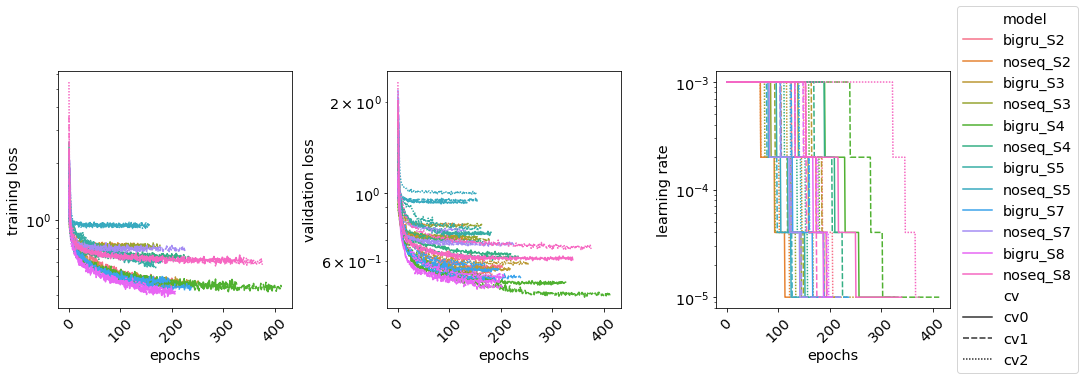

In [17]:
ids = container_1f.choose_best(
    partition="val",
    metric="keras_ce",
    groups_keep=["model", "covariate_key"]
)["run"]
container_1f.plot_training_overview(ids=ids)
plt.tight_layout()

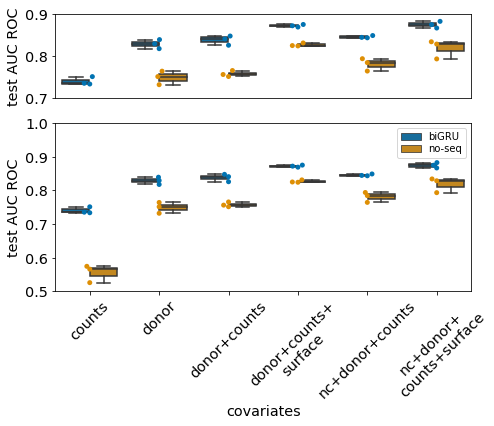

In [18]:
sns.set_palette("colorblind")
fig, axs = container_1f.plot_metrics_topmodel(
    x="covariate_key",
    hue="model",
    select_metric="keras_ce",
    select_partition="val",
    show_partition="test",
    subset=[["chain_key", "CONCAT"]],
    rename_levels=[
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+counts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"],
        ["model", "bigru", "biGRU"],
        ["model", "noseq", "no-seq"],
    ],
    plot_roc_only=True,
    ylim=[0.7, 0.9],
    xrot=45,
    show_swarm=True
)
axs[1].set_xlabel("covariates")
plt.tight_layout()
plt.savefig(figir+'main_1_f.pdf')
plt.show()

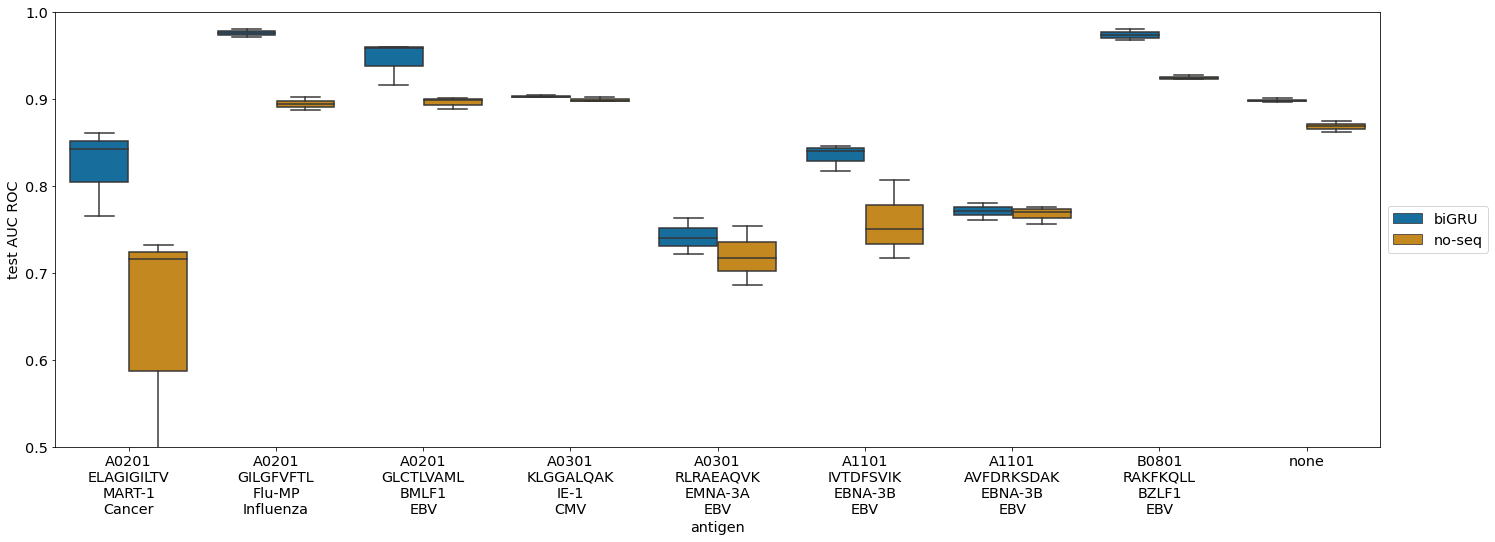

In [19]:
sns.set_palette("colorblind")
fig, axs = container_1f.plot_metrics_topmodel_split(
    hue="model",
    rename_levels=[
        ["model", "bigru", "biGRU"],
        ["model", "noseq", "no-seq"],
    ],
    select_metric="keras_ce",
    select_partition="val",
    show_partition="test",
    subset=[["chain_key", "CONCAT"], ["covariate_key", "S8"]],
    plot_roc_only=True,
    width_fig=25,
    height_fig=8,
    ylim=None,
    xrot=0,
    show_swarm=False,
    drop_last_label=False
)
axs[0].set_xlabel("antigen")
if True:
    axs[0].set_xticklabels([
        'A0201\nELAGIGILTV\nMART-1\nCancer', 
        'A0201\nGILGFVFTL\nFlu-MP\nInfluenza', 
        'A0201\nGLCTLVAML\nBMLF1\nEBV', 
        'A0301\nKLGGALQAK\nIE-1\nCMV',
        'A0301\nRLRAEAQVK\nEMNA-3A\nEBV',
        'A1101\nIVTDFSVIK\nEBNA-3B\nEBV', 
        'A1101\nAVFDRKSDAK\nEBNA-3B\nEBV', 
        'B0801\nRAKFKQLL\nBZLF1\nEBV',
        'none'
    ], rotation=0)
box = axs[0].get_position()
axs[0].set_position([box.x0, box.y0, box.width * 0.95, box.height])
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Scalars performance metrics mentioned in text:

In [20]:
results_tab_1f = container_1f.load_table(
    subset=[["chain_key", "CONCAT"]]
)
results_tab_1f = container_1f.reduce_table(
    tab=results_tab_1f,
    metric="keras_ce",
    partition="val",
    groups_keep=["covariate_key", "model"],
)

In [21]:
for x in np.unique(results_tab_1f["covariate_key"].values):
    print("%s: mean difference=%f, pval=%f" % (
        "".join(x.split("\n")),
        np.mean(results_tab_1f.loc[np.logical_and(
            results_tab_1f["covariate_key"].values == x,
            results_tab_1f["model"].values == "bigru", 
        ), "auc_test"].values) -
        np.mean(results_tab_1f.loc[np.logical_and(
            results_tab_1f["covariate_key"].values == x,
            results_tab_1f["model"].values == "noseq", 
        ), "auc_test"].values),
        scipy.stats.ttest_ind(
            a=results_tab_1f.loc[np.logical_and(
                results_tab_1f["covariate_key"].values == x,
                results_tab_1f["model"].values == "bigru", 
            ), "auc_test"].values,
            b=results_tab_1f.loc[np.logical_and(
                results_tab_1f["covariate_key"].values == x,
                results_tab_1f["model"].values == "noseq", 
            ), "auc_test"].values,
            equal_var=False
        )[1]
    ))

S2: mean difference=0.079455, pval=0.003477
S3: mean difference=0.080191, pval=0.001033
S4: mean difference=0.045240, pval=0.000125
S5: mean difference=0.184366, pval=0.002865
S7: mean difference=0.064585, pval=0.014892
S8: mean difference=0.055962, pval=0.036184


### Prediction errors 

In [22]:
results_tab_1f = container_1f.load_table(
    subset=[["chain_key", "CONCAT"]]
)
results_tab_1f = container_1f.reduce_table(
    tab=results_tab_1f,
    metric="keras_ce",
    partition="val",
    groups_keep=["covariate_key", "model"],
)
results_tab_1f = container_1f.rename_levels(
    tab=results_tab_1f,
    rename_levels=[
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+counts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"],
        ["model", "bigru", "biGRU"],
        ["model", "noseq", "no-seq"],
    ]
)

In [23]:
hue = "covariate_key"
models_seq = [
    ["s5_bigru_cce_1x1", "counts"],
    ["s2_bigru_cce_1x1", "donor"],
    ["s3_bigru_cce_1x1", "donor+counts"],
    ["s4_bigru_cce_1x1", "donor+counts+\nsurface"],
    ["s7_bigru_cce_1x1", "nc+donor+counts"],
    ["s8_bigru_cce_1x1", "nc+donor+\ncounts+surface"]
]
models_noseq = [
    ["s5_noseq_cce_1x1", "counts"],
    ["s2_noseq_cce_1x1", "donor"],
    ["s3_noseq_cce_1x1", "donor+counts"],
    ["s4_noseq_cce_1x1", "donor+counts+\nsurface"],
    ["s7_noseq_cce_1x1", "nc+donor+counts"],
    ["s8_noseq_cce_1x1", "nc+donor+\ncounts+surface"]
]
confusion_mat_noseq = np.zeros([len(models_seq), 3, 2, 2])
for i, _ in enumerate(models_seq):
    for j, cv in enumerate(["0", "1", "2"]):
        run0 = results_tab_1f["run"].values[np.logical_and(
            np.logical_and(
                results_tab_1f[hue].values == models_seq[i][1],
                results_tab_1f["model"].values == "biGRU",
            ),
            results_tab_1f["cv"].values == cv,
        )][0]
        yhat0 = np.load(
            grid_search_dir+"/10x_cd8/"+models_seq[i][0]+'/models/'+run0+"_yhat_test.npy"
        )
        yobs0 = scipy.sparse.load_npz(
            grid_search_dir+"/10x_cd8/"+models_seq[i][0]+'/models/'+run0+"_y_test.npz"
        )

        run1 = results_tab_1f["run"].values[np.logical_and(
            np.logical_and(
                results_tab_1f[hue].values == models_noseq[i][1],
                results_tab_1f["model"].values == "no-seq",
            ),
            results_tab_1f["cv"].values == cv,
        )][0]
        yhat1 = np.load(
            grid_search_dir+"/10x_cd8/"+models_noseq[i][0]+'/models/'+run1+"_yhat_test.npy"
        )
        yobs1 = scipy.sparse.load_npz(
            grid_search_dir+"/10x_cd8/"+models_noseq[i][0]+'/models/'+run1+"_y_test.npz"
        )
        assert not (yobs0 != yobs1).toarray().any()
        confusion_mat_noseq[i, j, 0, 0] = np.mean(np.logical_and(
            np.argmax(yhat0, axis=1).flatten() == np.argmax(yobs0, axis=1).flatten(),
            np.argmax(yhat1, axis=1).flatten() == np.argmax(yobs1, axis=1).flatten()
        ))
        confusion_mat_noseq[i, j, 1, 0] = np.mean(np.logical_and(
            np.argmax(yhat0, axis=1).flatten() != np.argmax(yobs0, axis=1).flatten(),
            np.argmax(yhat1, axis=1).flatten() == np.argmax(yobs1, axis=1).flatten()
        ))
        confusion_mat_noseq[i, j, 0, 1] = np.mean(np.logical_and(
            np.argmax(yhat0, axis=1).flatten() == np.argmax(yobs0, axis=1).flatten(),
            np.argmax(yhat1, axis=1).flatten() != np.argmax(yobs1, axis=1).flatten()
        ))
        confusion_mat_noseq[i, j, 1, 1] = np.mean(np.logical_and(
            np.argmax(yhat0, axis=1).flatten() != np.argmax(yobs0, axis=1).flatten(),
            np.argmax(yhat1, axis=1).flatten() != np.argmax(yobs1, axis=1).flatten()
        ))

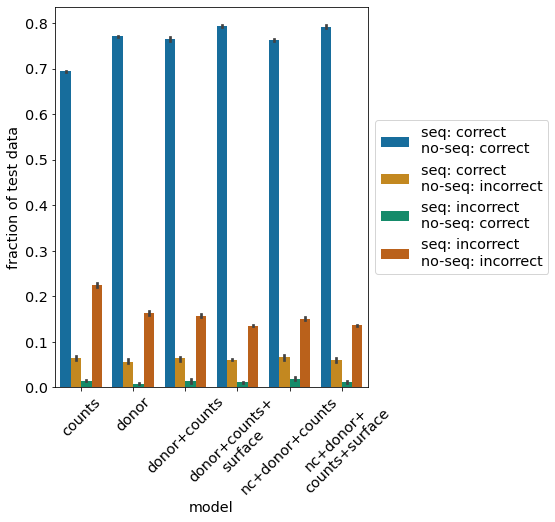

In [24]:
sns_data_confusion = pandas.concat([
    pandas.concat([pandas.DataFrame({
        "pie": [
            "seq: correct\nno-seq: correct",
            "seq: correct\nno-seq: incorrect",
            "seq: incorrect\nno-seq: correct",
            "seq: incorrect\nno-seq: incorrect"
        ],
        "value": confusion_mat_noseq[i, j].flatten(),
        "cv": str(j),
        "model": models_seq[i][1]
    }) for  j in range(confusion_mat_noseq.shape[1])])
 for  i in range(confusion_mat_noseq.shape[0])])

fig, axs = plt.subplots(1, 1, figsize=(7, 7))
sns.set_palette("colorblind")
sns.barplot(
    data=sns_data_confusion,
    x="model",
    hue="pie",
    y="value",
    ax=axs,
)   
axs.tick_params(axis='x', labelrotation=45)
axs.set_xlabel("model")
axs.set_ylabel("fraction of test data")
box = axs.get_position()
axs.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Fig. 1g

In [25]:
container_1g = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's8_bigru_cce_1x1',
        's8_linear_cce_1x1',
        's8_conv_cce_1x1',
        's8_sa_cce_1x1'
    ]
)
container_1g.load_all()

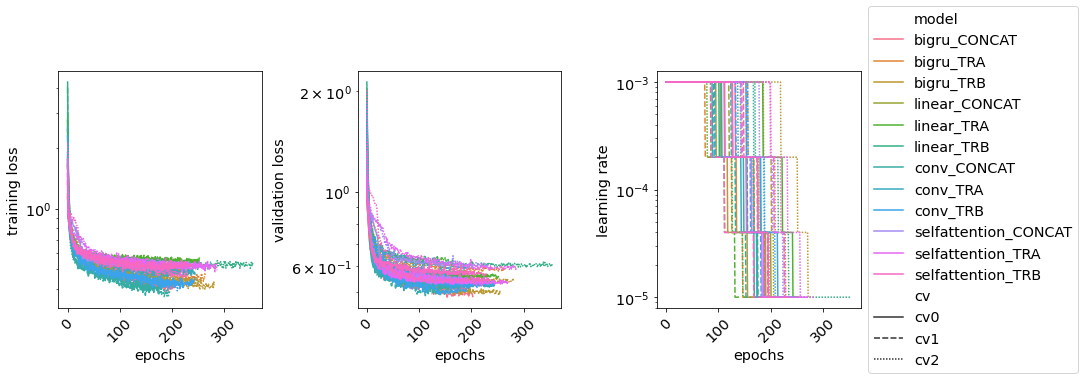

In [26]:
ids = container_1g.choose_best(
    partition="val",
    metric="keras_ce",
    groups_keep=["model", "chain_key"]
)["run"]
container_1g.plot_training_overview(ids=ids)
plt.tight_layout()

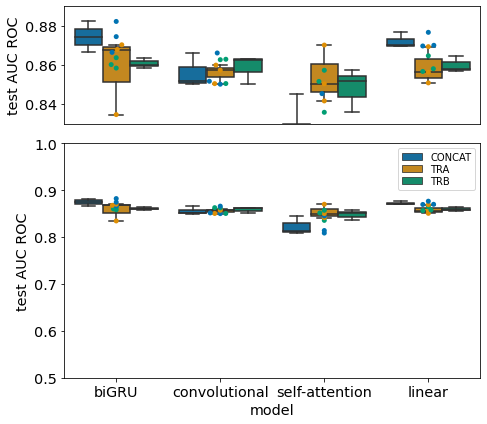

In [27]:
sns.set_palette("colorblind")
_, _ = container_1g.plot_metrics_topmodel(
    x="model",
    hue="chain_key",
    rename_levels=[
        ["model", "bigru", "biGRU"],
        ["model", "conv", "convolutional"],
        ["model", "selfattention", "self-attention"],
        ["model", "linear", "linear"]
    ],
    select_metric="keras_ce",
    select_partition="val",
    show_partition="test",
    plot_roc_only=True,
    show_swarm=True,
    ylim=[0.83, 0.89],
)
plt.tight_layout()
plt.savefig(figir+'main_1_g.pdf')
plt.show()

Scalars performance metrics mentioned in text:

In [28]:
results_tab_1g = container_1g.load_table()
results_tab_1g = container_1g.reduce_table(
    tab=results_tab_1g,
    metric="loss",
    partition="val",
    groups_keep=["model", "chain_key"]
)

In [29]:
print(
    results_tab_1g.groupby(["model", "chain_key"])["auc_test"].mean() -
    results_tab_1g.loc[results_tab_1g["model"].values == "linear", :].groupby("chain_key")["auc_test"].mean()
)

model          chain_key
bigru          CONCAT       0.002248
               TRA         -0.001208
               TRB          0.000954
conv           CONCAT      -0.016177
               TRA         -0.002912
               TRB         -0.001122
linear         CONCAT       0.000000
               TRA          0.000000
               TRB          0.000000
selfattention  CONCAT      -0.049411
               TRA         -0.004778
               TRB         -0.011611
Name: auc_test, dtype: float64


In [30]:
print(
    results_tab_1g.loc[results_tab_1g["chain_key"].values == "CONCAT", :].groupby("model")["auc_test"].mean() -
    results_tab_1g.loc[results_tab_1g["chain_key"].values == "TRA", :].groupby("model")["auc_test"].mean()
)
print(
    results_tab_1g.loc[results_tab_1g["chain_key"].values == "CONCAT", :].groupby("model")["auc_test"].mean() -
    results_tab_1g.loc[results_tab_1g["chain_key"].values == "TRB", :].groupby("model")["auc_test"].mean()
)

model
bigru            0.016796
conv             0.000076
linear           0.013341
selfattention   -0.031292
Name: auc_test, dtype: float64
model
bigru            0.013633
conv            -0.002715
linear           0.012340
selfattention   -0.025460
Name: auc_test, dtype: float64


In [31]:
print(
    (results_tab_1g.loc[results_tab_1g["chain_key"].values == "CONCAT", :].groupby("model")["auc_test"].mean() -
    results_tab_1g.loc[results_tab_1g["chain_key"].values == "TRA", :].groupby("model")["auc_test"].mean()).mean()
)
print(
    (results_tab_1g.loc[results_tab_1g["chain_key"].values == "CONCAT", :].groupby("model")["auc_test"].mean() -
    results_tab_1g.loc[results_tab_1g["chain_key"].values == "TRB", :].groupby("model")["auc_test"].mean()).mean()
)

-0.00026980794682046616
-0.0005502865355083708


In [32]:
scipy.stats.wilcoxon(
    x=results_tab_1g.loc[results_tab_1g["chain_key"].values == "CONCAT", "auc_test"].values, 
    y=results_tab_1g.loc[results_tab_1g["chain_key"].values == "TRA", "auc_test"].values, 
)

WilcoxonResult(statistic=37.0, pvalue=0.875329249147922)

In [33]:
scipy.stats.wilcoxon(
    x=results_tab_1g.loc[results_tab_1g["chain_key"].values == "CONCAT", "auc_test"].values, 
    y=results_tab_1g.loc[results_tab_1g["chain_key"].values == "TRB", "auc_test"].values, 
)

WilcoxonResult(statistic=33.0, pvalue=0.6378701798979456)

# Fig. 2

## Fig. 2a

In [34]:
container_2a = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's8_bigru_msle_1x1',
        's8_linear_msle_1x1',
        's8_conv_msle_1x1',
        's8_sa_msle_1x1'
    ]
)
container_2a.load_all(data="")

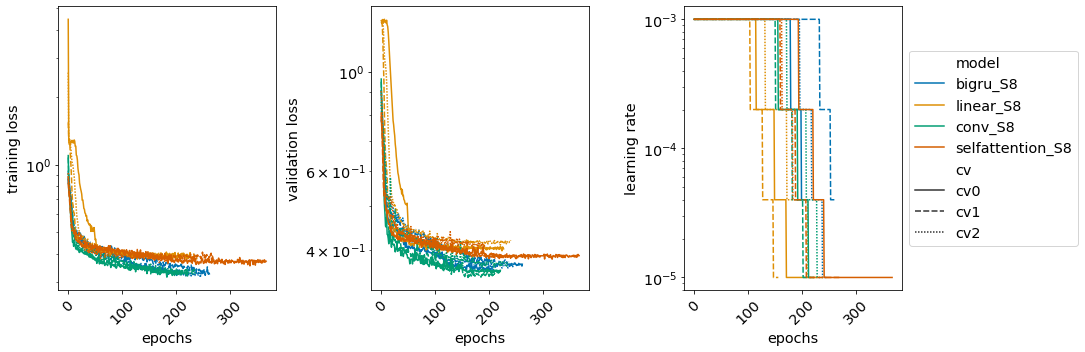

In [35]:
ids = container_2a.choose_best(
    partition="val",
    metric="keras_msle",
    groups_keep=["model", "covariate_key"]
)["run"]
container_2a.plot_training_overview(ids=ids)
plt.tight_layout()

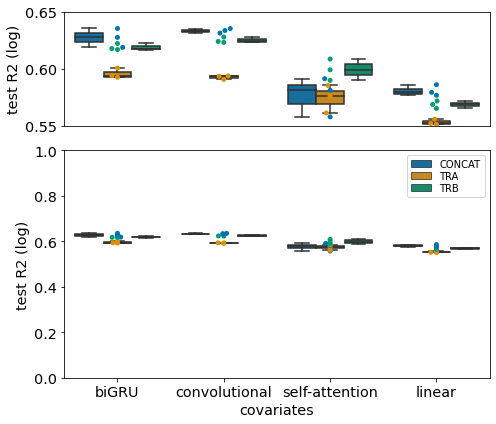

In [36]:
sns.set_palette("colorblind")
fig, axs = container_2a.plot_mse(
    x="model",
    hue="chain_key",
    rename_levels=[
        ["model", "bigru", "biGRU"],
        ["model", "conv", "convolutional"],
        ["model", "selfattention", "self-attention"],
        ["model", "linear", "linear"]
    ],
    select_metric="keras_msle",
    select_partition="val",
    show_partition="test",
    plot_only_r2=True,
    subset=[["covariate_key", "S8"]],
    y_lim=[0.55, 0.65],
    xrot=0,
    show_swarm=True
)
axs[1].set_xlabel("covariates")
plt.tight_layout()
plt.savefig(figir+'main_2a.pdf')
plt.show()

## Fig. 2b

In [37]:
container_2b = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's1_linear_msle_1x1',
        's1_bigru_msle_1x1',
        's2_linear_msle_1x1',
        's2_bigru_msle_1x1',
        's3_bigru_msle_1x1',
        's3_linear_msle_1x1',
        's4_bigru_msle_1x1',
        's4_linear_msle_1x1',
        's5_bigru_msle_1x1',
        's5_linear_msle_1x1',
        's6_bigru_msle_1x1',
        's6_linear_msle_1x1',
        's7_bigru_msle_1x1',
        's7_linear_msle_1x1',
        's8_bigru_msle_1x1',
        's8_linear_msle_1x1'
    ]
)
container_2b.load_all(data="")

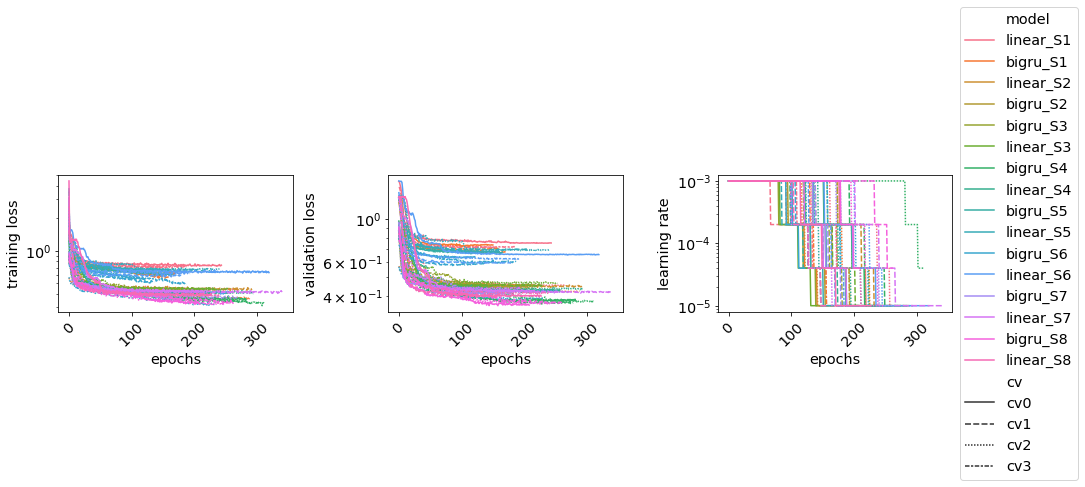

In [38]:
ids = container_2b.choose_best(
    partition="val",
    metric="keras_msle",
    groups_keep=["model", "covariate_key"]
)["run"]
container_2b.plot_training_overview(ids=ids)
plt.tight_layout()

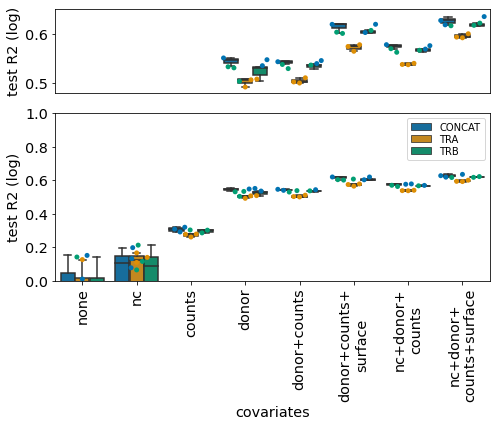

In [39]:
sns.set_palette("colorblind")
fig, axs = container_2b.plot_mse(
    x="covariate_key",
    hue="chain_key",
    select_metric="keras_msle",
    select_partition="val",
    show_partition="test",
    subset=[["model", "bigru"]],
    rename_levels=[
        ["covariate_key", "S1", "none"],
        ["covariate_key", "S6", "nc"],
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+\ncounts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"]
    ],
    plot_only_r2=True,
    y_lim=[0.48, 0.65],
    xrot=90,
    show_swarm=True
)
axs[1].set_xlabel("covariates")
plt.tight_layout()
plt.savefig(figir+'main_2b.pdf')
plt.show()

In [40]:
results_tab_2b = container_2b.load_table(
    subset=[["model", "bigru"]]
)
results_tab_2b = container_2b.reduce_table(
    tab=results_tab_2b,
    metric="keras_msle",
    partition="val",
    groups_keep=["covariate_key", "chain_key"]
)
results_tab_2b = container_2b.rename_levels(
    tab=results_tab_2b,
    rename_levels=[
        ["covariate_key", "S1", "none"],
        ["covariate_key", "S6", "nc"],
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+\ncounts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"]
    ]
)

In [41]:
print(np.mean(results_tab_2b.loc[np.logical_and(
    results_tab_2b["covariate_key"].values == "donor",
    results_tab_2b["chain_key"].values == "CONCAT"
), "r2log_test"]))
print(np.mean(results_tab_2b.loc[np.logical_and(
    results_tab_2b["covariate_key"].values == "donor+counts",
    results_tab_2b["chain_key"].values == "CONCAT"
), "r2log_test"]))
print(np.mean(results_tab_2b.loc[np.logical_and(
    results_tab_2b["covariate_key"].values == "nc+donor+\ncounts",
    results_tab_2b["chain_key"].values == "CONCAT"
), "r2log_test"]))

0.5452725248114804
0.5435646800603644
0.5749228106763422


In [42]:
print(
    np.mean(results_tab_2b.loc[np.logical_and(
        results_tab_2b["covariate_key"].values == "donor",
        results_tab_2b["chain_key"].values == "CONCAT"
    ), "r2log_test"])-
         np.mean(results_tab_2b.loc[np.logical_and(
        results_tab_2b["covariate_key"].values == "donor+counts+\nsurface",
        results_tab_2b["chain_key"].values == "CONCAT"
    ), "r2log_test"])
)
print(scipy.stats.ttest_ind(
    a=results_tab_2b.loc[np.logical_and(
        results_tab_2b["covariate_key"].values == "donor",
        results_tab_2b["chain_key"].values == "CONCAT"
    ), "r2log_test"],
    b=results_tab_2b.loc[np.logical_and(
        results_tab_2b["covariate_key"].values == "donor+counts+\nsurface",
        results_tab_2b["chain_key"].values == "CONCAT"
    ), "r2log_test"]
))
print(
    np.mean(results_tab_2b.loc[np.logical_and(
        results_tab_2b["covariate_key"].values == "nc+donor+\ncounts",
        results_tab_2b["chain_key"].values == "CONCAT"
    ), "r2log_test"]) -
        np.mean(results_tab_2b.loc[np.logical_and(
        results_tab_2b["covariate_key"].values == "nc+donor+\ncounts+surface",
        results_tab_2b["chain_key"].values == "CONCAT"
    ), "r2log_test"])
)
print(scipy.stats.ttest_ind(
    a=results_tab_2b.loc[np.logical_and(
        results_tab_2b["covariate_key"].values == "nc+donor+\ncounts",
        results_tab_2b["chain_key"].values == "CONCAT"
    ), "r2log_test"],
    b=results_tab_2b.loc[np.logical_and(
        results_tab_2b["covariate_key"].values == "nc+donor+\ncounts+surface",
        results_tab_2b["chain_key"].values == "CONCAT"
    ), "r2log_test"]
))

-0.06897588695302825
Ttest_indResult(statistic=-9.461063454079087, pvalue=0.0006961758969510015)
-0.05234538774879005
Ttest_indResult(statistic=-9.489585795672829, pvalue=0.0006881386973807896)


In [43]:
print(np.mean(results_tab_2b.loc[np.logical_and(
    results_tab_2b["covariate_key"].values == "nc+donor+\ncounts+surface",
    results_tab_2b["chain_key"].values == "CONCAT"
), "r2log_test"]))

0.6272681984251323


## Fig. 2c

In [44]:
container_2c_multi = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's8_bigru_msle_1x1',
        #'s8_linear_msle_1x1'
    ]
)
container_2c_multi.load_all(data="")
container_2c_single = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's8_bigru_msle_1x1_split'
    ]
)
container_2c_single.load_all(data="")

In [45]:
show_partition = "test"
results_tab_2c = container_2c_multi.load_table(
    subset=[]
)
results_tab_2c = container_2c_multi.reduce_table(
    tab=results_tab_2c,
    metric="keras_msle",
    partition="val",
    groups_keep=[]
)
results_tab_2c = container_2c_multi.rename_levels(
    tab=results_tab_2c
)
results_tab_2c = pandas.concat([
    pandas.DataFrame(dict([
        ("label", container_2c_multi.labels[run].tolist())
    ] + [
        (k + "_" + show_partition, v.flatten())
        for k, v in container_2c_multi.evaluations_custom[run][show_partition]["local"].items()
    ]))
    for i, run in enumerate(results_tab_2c["run"].values)
])
results_tab_2c["task"] = "multi"

In [46]:
results_tab_2c_2 = container_2c_single.load_table(
    subset=[]
)
results_tab_2c_2 = container_2c_single.reduce_table(
    tab=results_tab_2c_2,
    metric="keras_msle",
    partition="val",
    groups_keep=["labels_range"]
)
results_tab_2c_2 = pandas.concat([
    pandas.DataFrame(dict([
        ("label", container_2c_single.labels[run].tolist())
    ] + [
        (k + "_" + show_partition, v.flatten())
        for k, v in container_2c_single.evaluations_custom[run][show_partition]["global"].items()
    ]))
    for i, run in enumerate(results_tab_2c_2["run"].values)
])
results_tab_2c_2["task"] = "single"

In [47]:
results_tab_2c = pandas.concat([results_tab_2c, results_tab_2c_2], axis=0)
results_tab_2c["label"] = pandas.Categorical(
    results_tab_2c["label"].values,
    categories=np.sort(np.unique(results_tab_2c["label"].values))
)

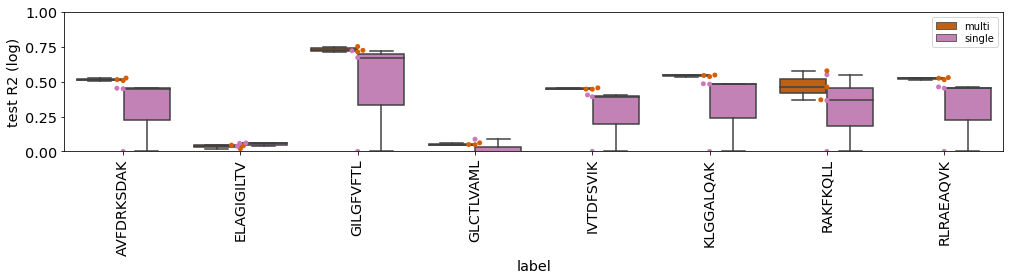

In [48]:
sns.set_palette(sns.color_palette("colorblind")[3:])
_ = container_2c_multi._plot_mse(
    sns_data=results_tab_2c,
    x="label",
    hue="task",
    plot_only_r2=True,
    xrot=90,
    y_lim=None,
    width_fig=14,
    show_swarm=True
)
plt.tight_layout()
plt.savefig(figir+"main_2c.pdf")
plt.show()

# Figure 3

## Fig. 3c

In [49]:
container_3c = tm.train.SummaryContainer(
    indir=grid_search_dir + "/iedb/", 
    gs_ids=[
        's_bilstm',
        's_bilstm_separate',
        's_bigru',
        's_bigru_separate',
        's_sa',
        's_conv',
        's_inception',
        's_nettcr',
        's_linear'
    ]
)
container_3c.load_all()

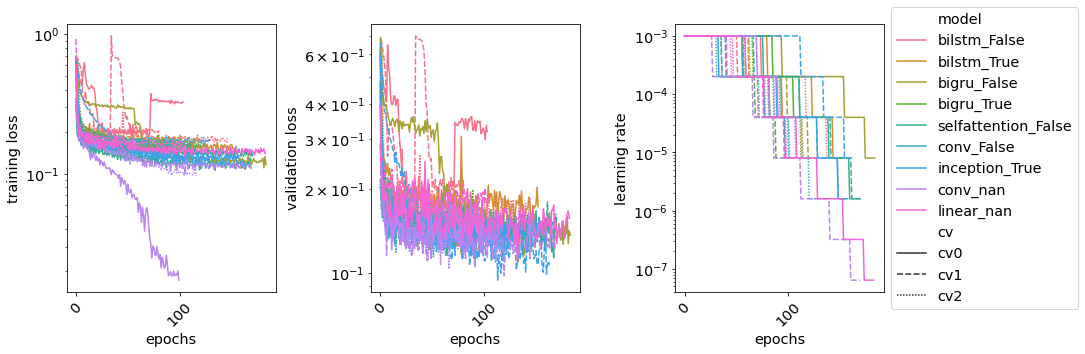

In [50]:
ids = container_3c.choose_best(
    partition="val",
    metric="keras_ce",
    groups_keep=["model", "split"]
)["run"]
container_3c.plot_training_overview(ids=ids)
plt.tight_layout()

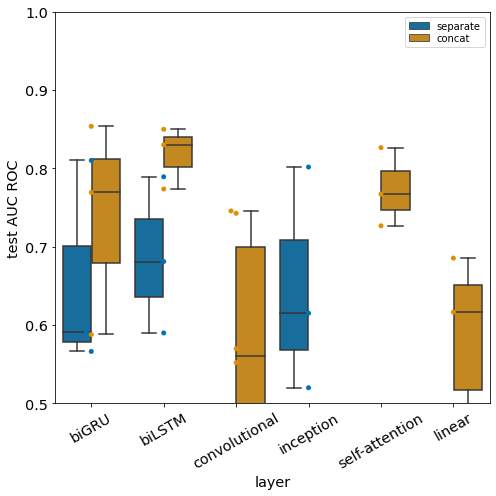

In [116]:
sns.set_palette("colorblind")
fig, axs = container_3c.plot_metrics_topmodel(
    x="model",
    hue="split",
    select_metric="keras_ce",
    select_partition="val",
    show_partition="test",
    rename_levels=[
        ["split", "True", "separate"],
        ["split", "False", "concat"],
        ["split", "nan", "concat"],
        ["model", "bigru", "biGRU"],
        ["model", "bilstm", "biLSTM"],
        ["model", "conv", "convolutional"],
        ["model", "inception", "inception"],
        ["model", "selfattention", "self-attention"],
        ["model", "linear", "linear"]
    ],
    plot_roc_only=True,
    show_swarm=True,
    xrot=30
)
axs[0].set_xlabel("layer")
plt.tight_layout()
plt.savefig(figir+'main_3c.pdf')
plt.show()

Scalars performance metrics mentioned in text:

In [52]:
results_tab_3c = container_3c.load_table(
    subset=[]
)
results_tab_3c = container_3c.reduce_table(
    tab=results_tab_3c,
    metric="keras_ce",
    partition="val",
    groups_keep=["model", "split"]
)
results_tab_3c = container_3c.rename_levels(
    tab=results_tab_3c,
    rename_levels=[
        ["split", "True", "separate"],
        ["split", "False", "concat"],
        ["split", "nan", "concat"]
    ]
)

In [53]:
print(
    results_tab_3c.groupby(["model", "split"])["auc_test"].mean()
)
print(
    results_tab_3c.loc[results_tab_3c["split"].values == "concat", :].groupby(["model"])["auc_test"].mean().mean()
)
print(
    results_tab_3c.loc[results_tab_3c["split"].values == "concat", :].groupby(["model"])["auc_test"].mean().std()
)
print(
    results_tab_3c.loc[results_tab_3c["split"].values == "separate", :].groupby(["model"])["auc_test"].mean().mean()
)
print(
    results_tab_3c.loc[results_tab_3c["split"].values == "separate", :].groupby(["model"])["auc_test"].mean().std()
)

model          split   
bigru          separate    0.655890
               concat      0.737028
bilstm         separate    0.686771
               concat      0.818022
conv           separate         NaN
               concat      0.587232
inception      separate    0.645618
               concat           NaN
linear         separate         NaN
               concat      0.573334
selfattention  separate         NaN
               concat      0.773546
Name: auc_test, dtype: float64
0.6978322708742798
0.11118281125263589
0.6627598922854687
0.021418935804835046


## Fig. S1b

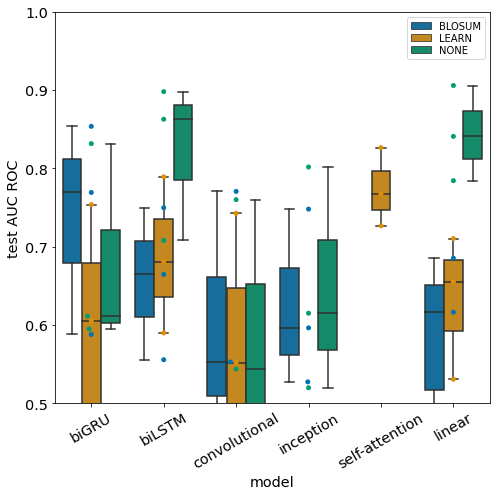

In [118]:
# Need to add aa_embedding manually based on model ID here as this was not saved in 
# runparams. In the future, one could use plot_top_model directly to create this plot.
sns.set_palette("colorblind")
results_tab_s1b = container_3c.load_table(
    subset=[]
)
results_tab_s1b["aa_embedding"] = [x.split("_")[3] for x in list(results_tab_s1b.index)]
results_tab_s1b = container_3c.reduce_table(
    tab=results_tab_s1b,
    metric="keras_ce",
    partition="val",
    groups_keep=["model", "aa_embedding"]
)
results_tab_s1b = container_3c.rename_levels(
    tab=results_tab_s1b,
    rename_levels=[
        ["model", "bigru", "biGRU"],
        ["model", "bilstm", "biLSTM"],
        ["model", "conv", "convolutional"],
        ["model", "inception", "inception"],
        ["model", "selfattention", "self-attention"],
        ["model", "linear", "linear"]
    ]
)
container_3c._plot_best_model(
    sns_data=results_tab_s1b,
    x="model",
    hue="aa_embedding",
    show_partition="test",
    width_fig=7,
    height_fig=7,
    plot_f1=False,
    plot_roc_only=True,
    plot_tp_only=False,
    plot_fp_only=False,
    xrot=30,
    ylim=None,
    show_swarm=True
)
axs[0].set_xlabel("layer")
plt.tight_layout()
plt.savefig(figir+'supp_1b.pdf')
plt.show()

## Fig. 3d

In [55]:
container_3d_multi = tm.train.SummaryContainer(
    indir=grid_search_dir + "/iedb/", 
    gs_ids=[
        's_bilstm',
        's_bilstm_separate',
        's_bigru',
        's_bigru_separate',
        's_nettcr',
        's_linear'
    ]
)
container_3d_multi.load_all()
container_3d_single = tm.train.SummaryContainer(
    indir=grid_search_dir + "/iedb_categ/", 
    gs_ids=[
        's_linear_split'
    ]
)
container_3d_single.load_all()

In [56]:
show_partition = "test"
results_tab_3d_1 = container_3d_multi.load_table(
    subset=[]
)
results_tab_3d_1 = container_3d_multi.reduce_table(
    tab=results_tab_3d_1,
    metric="keras_ce",
    partition="val",
    groups_keep=[]
)
results_tab_3d_1 = container_3d_multi.rename_levels(
    tab=results_tab_3d_1
)
results_tab_3d_1 = pandas.concat([
    pandas.DataFrame(dict([
        (k, [v[i] for x in container_3d_multi.peptide_seqs_unique[run]])
        for k, v in results_tab_3d_1.items()
    ] + [
        ("label", container_3d_multi.peptide_seqs_unique[run])
    ] + [
        (k + "_" + show_partition, v.flatten())
        for k, v in container_3d_multi.evaluations_custom[run][show_partition]["local"].items()
    ]))
    for i, run in enumerate(results_tab_3d_1["run"].values)
])
# Add label-wise F1 score
results_tab_3d_1["f1_" + show_partition] = 2*results_tab_3d_1["prec_" + show_partition].values * results_tab_3d_1["rec_" + show_partition].values /\
    (results_tab_3d_1["prec_" + show_partition].values + results_tab_3d_1["rec_" + show_partition].values + 1e-10)
results_tab_3d_1["task"] = "embedding"

In [57]:
results_tab_3d_2 = container_3d_single.load_table(
    subset=[]
)
results_tab_3d_2 = container_3d_single.reduce_table(
    tab=results_tab_3d_2,
    metric="keras_ce",
    partition="val",
    groups_keep=["labels_range"]
)
results_tab_3d_2 = pandas.concat([
    pandas.DataFrame(dict([
        (k, v[i])
        for k, v in results_tab_3d_2.items()
    ] + [
        ("label", results_tab_3d_2.loc[results_tab_3d_2["run"].values == run, "labels_range"].values[0].split("['")[1].split("']")[0])
    ] + [
        (k + "_" + show_partition, v.flatten())
        for k, v in container_3d_single.evaluations_custom[run][show_partition]["global"].items()
    ]))
    for i, run in enumerate(results_tab_3d_2["run"].values)
])
# Add label-wise F1 score
results_tab_3d_2["f1_" + show_partition] = 2*results_tab_3d_2["prec_" + show_partition].values * results_tab_3d_2["rec_" + show_partition].values /\
    (results_tab_3d_2["prec_" + show_partition].values + results_tab_3d_2["rec_" + show_partition].values + 1e-10)
results_tab_3d_2["task"] = "categorical"

In [58]:
results_tab_3d = pandas.concat([results_tab_3d_1, results_tab_3d_2], axis=0)

In [59]:
antigens_iedb_iedb_categ_split = [
    'AMFWSVPTV',
    'CINGVCWTV', 
    'ELAGIGILTV', 
    'FLYNLLTRV', 
    'GILGFVFTL', 
    'GLCTLVAML', 
    'KLSALGINAV', 
    'LLWNGPMAV', 
    'NLVPMVATV', 
    'VLFGLGFAI',
    'YVLDHLIVV'
]

In [60]:
results_tab_3d = results_tab_3d.loc[
    [x in antigens_iedb_iedb_categ_split for x in results_tab_3d["label"].values], :].copy()

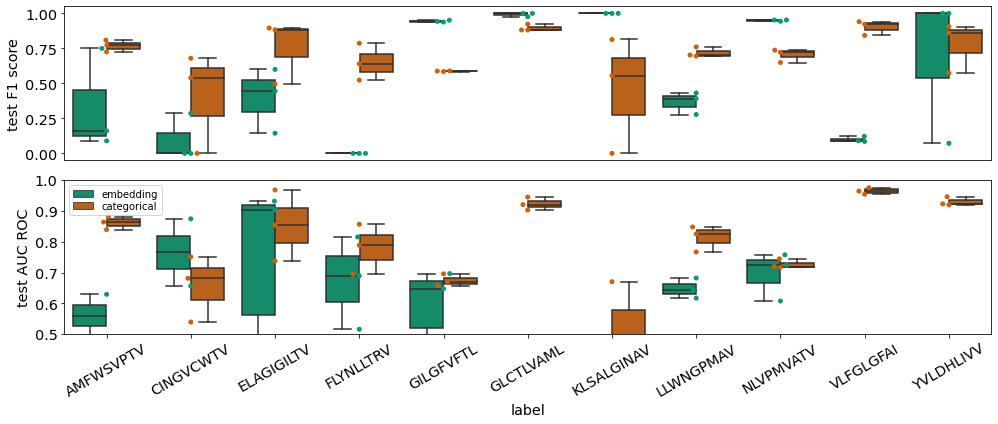

In [61]:
sns.set_palette(sns.color_palette("colorblind")[2:])
_ = container_3d_multi._plot_best_model(
    sns_data=results_tab_3d,
    x="label",
    hue="task",
    show_partition="test", 
    plot_f1=True, 
    plot_fp_only=False, 
    plot_tp_only=False,
    plot_roc_only=False,
    ylim=None,
    xrot=30,
    width_fig=14,
    height_fig=7,
    show_swarm=True
)
plt.tight_layout()
plt.savefig(figir+"main_3d.pdf")
plt.show()

Scalars performance metrics mentioned in text:

In [62]:
print(
    results_tab_3d.loc[results_tab_3d["task"].values == "categorical", :].groupby(["label"])["auc_test"].mean() -
    results_tab_3d.loc[results_tab_3d["task"].values == "embedding", :].groupby(["label"])["auc_test"].mean()
)

label
AMFWSVPTV     0.301476
CINGVCWTV    -0.108360
ELAGIGILTV    0.167107
FLYNLLTRV     0.106199
GILGFVFTL     0.095570
GLCTLVAML          NaN
KLSALGINAV         NaN
LLWNGPMAV     0.166601
NLVPMVATV     0.030745
VLFGLGFAI     0.538194
YVLDHLIVV     0.473368
Name: auc_test, dtype: float64


In [63]:
print(
    np.sum(
        results_tab_3d.loc[results_tab_3d["task"].values == "categorical", :].groupby(["label"])["auc_test"].mean() >
        results_tab_3d.loc[results_tab_3d["task"].values == "embedding", :].groupby(["label"])["auc_test"].mean()
    )
)
print(len(np.unique(results_tab_3d["label"].values)))

8
11


In [64]:
scipy.stats.wilcoxon(
    x=results_tab_3d.loc[results_tab_3d["task"].values == "categorical", "auc_test"].values,
    y=results_tab_3d.loc[results_tab_3d["task"].values == "embedding", "auc_test"].values
)

/Users/david.fischer/opt/miniconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/Users/david.fischer/opt/miniconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


WilcoxonResult(statistic=22.0, pvalue=3.859027284068544e-06)

In [65]:
for x in np.unique(results_tab_3d["label"].values):
    print(x)
    print(scipy.stats.ttest_ind(
        a=results_tab_3d.loc[np.logical_and(
            results_tab_3d["label"].values == x,
            results_tab_3d["task"].values == "categorical"
        ), "auc_test"].values,
        b=results_tab_3d.loc[np.logical_and(
            results_tab_3d["label"].values == x,
            results_tab_3d["task"].values == "embedding"
        ), "auc_test"].values,
        equal_var=False
    ))

AMFWSVPTV
Ttest_indResult(statistic=nan, pvalue=nan)
CINGVCWTV
Ttest_indResult(statistic=nan, pvalue=nan)
ELAGIGILTV
Ttest_indResult(statistic=0.6922751708930572, pvalue=0.5514178663742362)
FLYNLLTRV
Ttest_indResult(statistic=1.075216337831277, pvalue=0.3591577656230434)
GILGFVFTL
Ttest_indResult(statistic=1.0040091353771168, pvalue=0.41857634914953307)
GLCTLVAML
Ttest_indResult(statistic=nan, pvalue=nan)
KLSALGINAV
Ttest_indResult(statistic=nan, pvalue=nan)
LLWNGPMAV
Ttest_indResult(statistic=5.4261930698020855, pvalue=0.006483181120142847)
NLVPMVATV
Ttest_indResult(statistic=0.6638956360451317, pvalue=0.5708660435749447)
VLFGLGFAI
Ttest_indResult(statistic=20.837824742332614, pvalue=0.0013301147258040751)
YVLDHLIVV
Ttest_indResult(statistic=nan, pvalue=nan)


## Fig. 3e

Prediction format: The IEDB trained model was run on all antigens of 10x data set, yielding a vector of predictions and an accompanying vector of labels. This vector is restructured into a list of metrics by label. The 10x trained models are in the split format, which means that one prediction per label is given in the 1D format.

In [66]:
container_3e_embedding = tm.train.SummaryContainer(
    indir=grid_search_dir + "/iedb/", 
    gs_ids=[
        's_bilstm',
        's_bilstm_separate',
        's_bigru',
        's_bigru_separate',
        's_nettcr',
        's_linear'
    ]
)
container_3e_embedding.load_all(data="10x_cd8", load_peptide_seqs_by_dataset=True)
container_3e_categ = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's3_linear_cce_1x1_split'
    ]
)
container_3e_categ.load_all(data="", load_peptide_seqs_by_dataset=True)

In [67]:
show_partition = "test"
results_tab_3e_1 = container_3e_embedding.load_table(
    subset=[]
)
results_tab_3e_1 = container_3e_embedding.reduce_table(
    tab=results_tab_3e_1,
    metric="keras_ce",
    partition="val",
    groups_keep=[]
)
results_tab_3e_1 = container_3e_embedding.rename_levels(
    tab=results_tab_3e_1
)
results_tab_3e_1 = pandas.concat([
    pandas.DataFrame(dict([
        (k, [v[i] for x in container_3e_embedding.peptide_seqs_unique[run]])
        for k, v in results_tab_3e_1.items()
    ] + [
        ("label", container_3e_embedding.peptide_seqs_unique[run])
    ] + [
        (k + "_" + show_partition, v.flatten())
        for k, v in container_3e_embedding.evaluations_custom[run][show_partition]["local"].items()
    ]))
    for i, run in enumerate(results_tab_3e_1["run"].values)
])
# Add label-wise F1 score
results_tab_3e_1["f1_" + show_partition] = 2*results_tab_3e_1["prec_" + show_partition].values * results_tab_3e_1["rec_" + show_partition].values /\
    (results_tab_3e_1["prec_" + show_partition].values + results_tab_3e_1["rec_" + show_partition].values + 1e-10)
results_tab_3e_1["task"] = "embedding"

In [68]:
results_tab_3e_2 = container_3e_categ.load_table(
    subset=[]
)
results_tab_3e_2 = container_3e_categ.reduce_table(
    tab=results_tab_3e_2,
    metric="keras_ce",
    partition="val",
    groups_keep=["labels_range"]
)
results_tab_3e_2 = pandas.concat([
    pandas.DataFrame(dict([
        (k, v[i])
        for k, v in results_tab_3e_2.items()
    ] + [
        ("label", container_3e_categ.labels[run][0])
    ] + [
        (k + "_" + show_partition, v.flatten())
        for k, v in container_3e_categ.evaluations_custom[run][show_partition]["global"].items()
    ]))
    for i, run in enumerate(results_tab_3e_2["run"].values)
])
# Add label-wise F1 score
results_tab_3e_2["f1_" + show_partition] = 2*results_tab_3e_2["prec_" + show_partition].values * results_tab_3e_2["rec_" + show_partition].values /\
    (results_tab_3e_2["prec_" + show_partition].values + results_tab_3e_2["rec_" + show_partition].values + 1e-10)
results_tab_3e_2["task"] = "categorical"

In [69]:
results_tab_3e = pandas.concat([results_tab_3e_1, results_tab_3e_2], axis=0)

In [70]:
# Take out antigens that do not occur in 10x data set:
results_tab_3e = results_tab_3e.loc[
    [x in np.unique(results_tab_3e_2["label"]) for x in results_tab_3e["label"].values], :].copy()

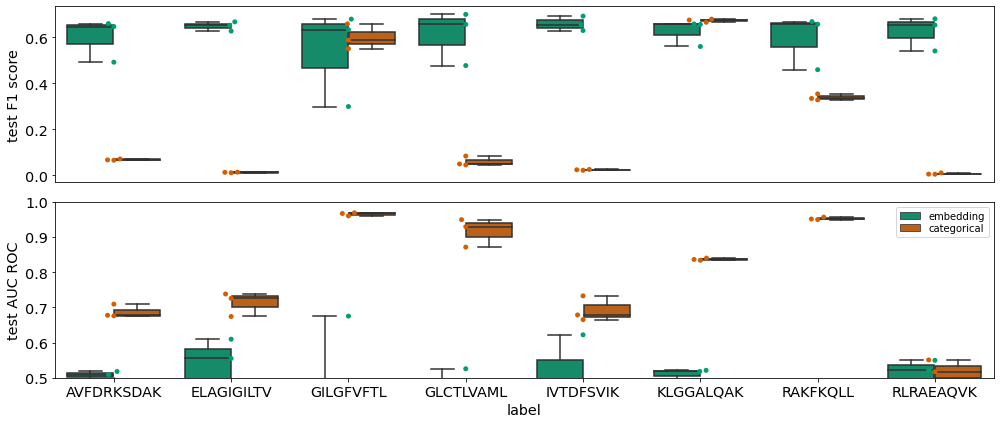

In [71]:
sns.set_palette(sns.color_palette("colorblind")[2:])
_ = container_3e_embedding._plot_best_model(
    sns_data=results_tab_3e,
    x="label",
    hue="task",
    show_partition="test", 
    plot_f1=True, 
    plot_fp_only=False, 
    plot_tp_only=False,
    plot_roc_only=False,
    ylim=[0, 1],
    xrot=0,
    width_fig=14,
    height_fig=6,
    show_swarm=True
)
plt.tight_layout()
plt.savefig(figir+"main_3e.pdf")
plt.show()

Scalars performance metrics mentioned in text:

In [72]:
print(
    results_tab_3e.loc[results_tab_3e["task"].values == "categorical", :].groupby(["label"])["auc_test"].mean() -
    results_tab_3e.loc[results_tab_3e["task"].values == "embedding", :].groupby(["label"])["auc_test"].mean()
)

label
AVFDRKSDAK    0.180503
ELAGIGILTV    0.177811
GILGFVFTL     0.567972
GLCTLVAML     0.488660
IVTDFSVIK     0.184400
KLGGALQAK     0.326907
RAKFKQLL      0.481934
RLRAEAQVK     0.004196
Name: auc_test, dtype: float64


In [73]:
print(
    np.sum(
        results_tab_3e.loc[results_tab_3e["task"].values == "categorical", :].groupby(["label"])["auc_test"].mean() >
        results_tab_3e.loc[results_tab_3e["task"].values == "embedding", :].groupby(["label"])["auc_test"].mean()
    )
)
print(len(np.unique(results_tab_3e["label"].values)))

8
8


In [74]:
scipy.stats.wilcoxon(
    x=results_tab_3e.loc[results_tab_3e["task"].values == "categorical", "auc_test"].values,
    y=results_tab_3e.loc[results_tab_3e["task"].values == "embedding", "auc_test"].values
)

WilcoxonResult(statistic=1.0, pvalue=2.0705605648246455e-05)

In [75]:
for x in np.unique(results_tab_3e["label"].values):
    print(x)
    print(scipy.stats.ttest_ind(
        a=results_tab_3e.loc[np.logical_and(
            results_tab_3e["label"].values == x,
            results_tab_3e["task"].values == "categorical"
        ), "auc_test"].values,
        b=results_tab_3e.loc[np.logical_and(
            results_tab_3e["label"].values == x,
            results_tab_3e["task"].values == "embedding"
        ), "auc_test"].values,
        equal_var=False
    ))

AVFDRKSDAK
Ttest_indResult(statistic=14.106369078017849, pvalue=0.0004180209858193)
ELAGIGILTV
Ttest_indResult(statistic=3.3146374968357666, pvalue=0.05561719674905146)
GILGFVFTL
Ttest_indResult(statistic=4.082812980297028, pvalue=0.05501467856397888)
GLCTLVAML
Ttest_indResult(statistic=9.052862822268706, pvalue=0.003352518432494773)
IVTDFSVIK
Ttest_indResult(statistic=2.9485002496687613, pvalue=0.07578417145705896)
KLGGALQAK
Ttest_indResult(statistic=33.86164860711005, pvalue=0.0005734617874443309)
RAKFKQLL
Ttest_indResult(statistic=60.88458766618888, pvalue=9.802184107568452e-05)
RLRAEAQVK
Ttest_indResult(statistic=0.12814277661226975, pvalue=0.9044542352745528)


# Supp. Fig. 1

## Supp. Fig. 1a

In [76]:
container_s1a = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's3_bigru_cce_noaa',
        's3_bigru_cce_blosum',
        's3_bigru_cce_1x1',
        's3_linear_cce_noaa',
        's3_linear_cce_blosum',
        's3_linear_cce_1x1'
    ]
)
container_s1a.load_all()

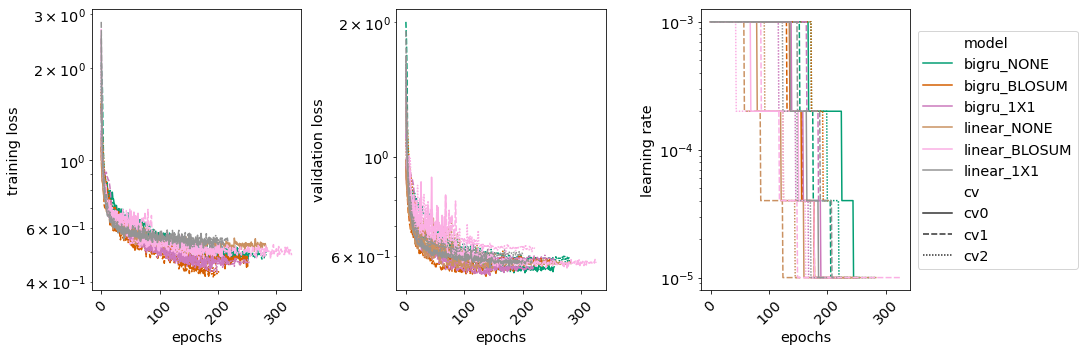

In [77]:
ids = container_s1a.choose_best(
    partition="val",
    metric="keras_ce",
    groups_keep=["model", "aa_embedding_key"],
    subset=[["chain_key", "CONCAT"]],
)["run"]
container_s1a.plot_training_overview(ids=ids)
plt.tight_layout()

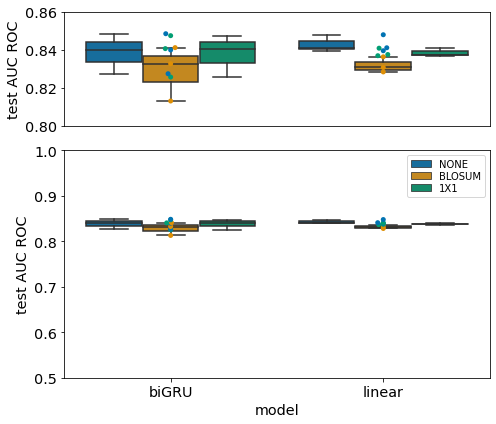

In [78]:
sns.set_palette("colorblind")
_, _ = container_s1a.plot_metrics_topmodel(
    x="model",
    hue="aa_embedding_key",
    rename_levels=[
        ["model", "bigru", "biGRU"],
        ["model", "linear", "linear"]
    ],
    select_metric="keras_ce",
    select_partition="val",
    show_partition="test",
    plot_roc_only=True,
    ylim=[0.8, 0.86],
    subset=[["chain_key", "CONCAT"]],
    show_swarm=True
)
plt.tight_layout()
plt.savefig(figir+'supp_1_a.pdf')
plt.show()

# Supp. Fig. 4

## Supp. Fig. 4a

In [79]:
container_s4a = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's1_bigru_cce_1x1',
        's1_linear_cce_1x1',
        's2_bigru_cce_1x1',
        's2_linear_cce_1x1',
        's3_bigru_cce_1x1',
        's3_linear_cce_1x1',
        's5_bigru_cce_1x1',
        's5_linear_cce_1x1',
        's6_bigru_cce_1x1',
        's6_linear_cce_1x1',
        's7_bigru_cce_1x1',
        's7_linear_cce_1x1',
        's8_bigru_cce_1x1',
        's8_linear_cce_1x1'
    ]
)
container_s4a.load_all(data="vdjdb_matched")

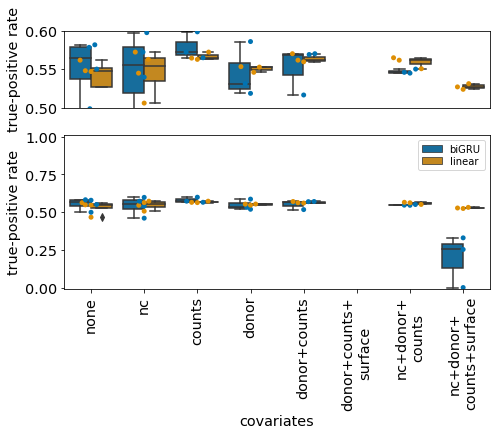

In [80]:
sns.set_palette("colorblind")
fig, axs = container_s4a.plot_metrics_topmodel(
    x="covariate_key",
    hue="model",
    select_metric="keras_ce",
    select_partition="val",
    show_partition="test",
    subset=[["chain_key", "CONCAT"]],
    rename_levels=[
        ["covariate_key", "S1", "none"],
        ["covariate_key", "S6", "nc"],
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+\ncounts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"],
        ["model", "bigru", "biGRU"],
        ["model", "linear", "linear"],
    ],
    plot_tp_only=True,
    ylim=[0.5, 0.6],
    width_fig=7,
    xrot=90,
    show_swarm=True
)
axs[1].set_xlabel("covariates")
plt.tight_layout()
plt.savefig(figir+"supp_4a.pdf")
plt.show()

## Supp. Fig. 4b

In [81]:
container_s4b = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's1_bigru_cce_1x1',
        's1_linear_cce_1x1',
        's2_bigru_cce_1x1',
        's2_linear_cce_1x1',
        's3_bigru_cce_1x1',
        's3_linear_cce_1x1',
        's5_bigru_cce_1x1',
        's5_linear_cce_1x1',
        's6_bigru_cce_1x1',
        's6_linear_cce_1x1',
        's7_bigru_cce_1x1',
        's7_linear_cce_1x1',
        's8_bigru_cce_1x1',
        's8_linear_cce_1x1'
    ]
)
container_s4b.load_all(data="vdjdb_unmatched")

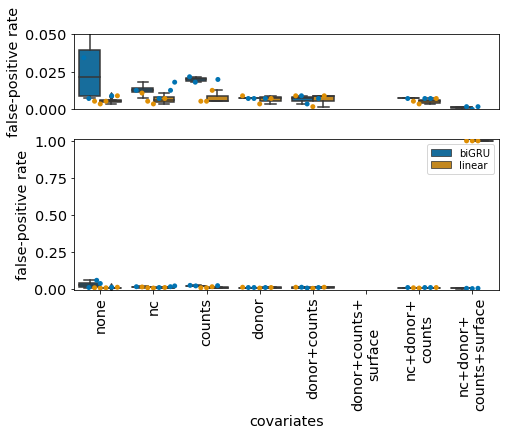

In [82]:
sns.set_palette("colorblind")
fig, axs = container_s4b.plot_metrics_topmodel(
    x="covariate_key",
    hue="model",
    select_metric="keras_ce",
    select_partition="val",
    show_partition="test",
    subset=[["chain_key", "CONCAT"]],
    rename_levels=[
        ["covariate_key", "S1", "none"],
        ["covariate_key", "S6", "nc"],
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+\ncounts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"],
        ["model", "bigru", "biGRU"],
        ["model", "linear", "linear"],
    ],
    plot_fp_only=True,
    ylim=[0, 0.05],
    width_fig=7,
    xrot=90,
    show_swarm=True
)
axs[1].set_xlabel("covariates")
plt.tight_layout()
plt.savefig(figir+"supp_4b.pdf")
plt.show()

## Supp. Fig. 4c

In [83]:
container_s4c = tm.train.SummaryContainer(
    indir=grid_search_dir + "/10x_cd8/", 
    gs_ids=[
        's1_bigru_cce_1x1',
        's1_linear_cce_1x1',
        's2_bigru_cce_1x1',
        's2_linear_cce_1x1',
        's3_bigru_cce_1x1',
        's3_linear_cce_1x1',
        's5_bigru_cce_1x1',
        's5_linear_cce_1x1',
        's6_bigru_cce_1x1',
        's6_linear_cce_1x1',
        's7_bigru_cce_1x1',
        's7_linear_cce_1x1',
        's8_bigru_cce_1x1',
        's8_linear_cce_1x1'
    ]
)
container_s4c.load_all(data="iedb_unmatched")

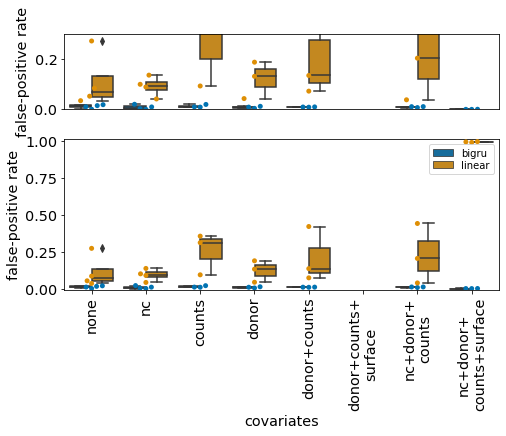

In [84]:
sns.set_palette("colorblind")
fig, axs = container_s4c.plot_metrics_topmodel(
    x="covariate_key",
    hue="model",
    select_metric="keras_ce",
    select_partition="val",
    show_partition="test",
    subset=[["chain_key", "CONCAT"]],
    rename_levels=[
        ["covariate_key", "S1", "none"],
        ["covariate_key", "S6", "nc"],
        ["covariate_key", "S5", "counts"],
        ["covariate_key", "S2", "donor"],
        ["covariate_key", "S3", "donor+counts"],
        ["covariate_key", "S4", "donor+counts+\nsurface"],
        ["covariate_key", "S7", "nc+donor+\ncounts"],
        ["covariate_key", "S8", "nc+donor+\ncounts+surface"]
    ],
    plot_fp_only=True,
    ylim=[0, 0.3],
    width_fig=7,
    xrot=90,
    show_swarm=True
)
axs[1].set_xlabel("covariates")
plt.tight_layout()
plt.savefig(figir+"supp_4c.pdf")
plt.show()

# Supp. Fig. 5

## Supp. Fig. 5a (Test set: unseen low frequency antigens from IEDB)

In [85]:
container_5a = tm.train.SummaryContainer(
    indir=grid_search_dir + "/iedb_categ/", 
    gs_ids=[
        's_linear_extrapolate_antigens',
        's_bigru_extrapolate_antigens',
        's_inception_extrapolate_antigens'
    ]
)
container_5a.load_all(data="", load_peptide_seqs_by_dataset=False)

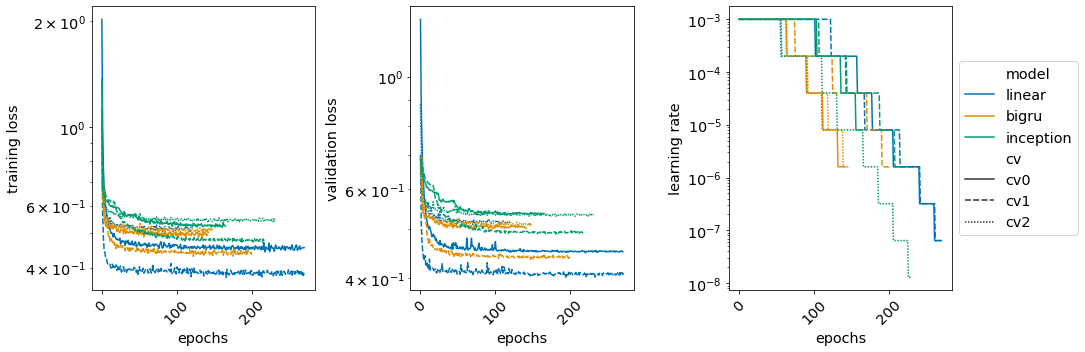

In [86]:
ids = container_5a.choose_best(
    partition="val",
    metric="keras_ce",
    groups_keep=["model"]
)["run"]
container_5a.plot_training_overview(ids=ids)
plt.tight_layout()

In [87]:
results_tab_s5a = container_5a.load_table(
    subset=[]
)
results_tab_s5a = container_5a.reduce_table(
    tab=results_tab_s5a,
    metric="keras_ce",
    partition="val",
    groups_keep=["model"]
)
results_tab_s5a = container_5a.rename_levels(
    tab=results_tab_s5a,
    rename_levels=[]
)
results_tab_s5a = pandas.concat([
    pandas.DataFrame(dict([
        (k, [v[i] for x in range(len(container_5a.peptide_seqs_unique[run]))])
        for k, v in results_tab_s5a.items()
    ] + [
        ("label", container_5a.peptide_seqs_unique[run])
    ] + [
        (k + "_" + show_partition, v.flatten())
        for k, v in container_5a.evaluations_custom[run][show_partition]["local"].items()
    ]))
    for i, run in enumerate(results_tab_s5a["run"].values)
])
# Add label-wise F1 score
for x in ["train", "val", "test"]:
    results_tab_s5a["f1_" + x] = 2*results_tab_s5a["prec_" + x].values * results_tab_s5a["rec_" + x].values /\
        (results_tab_s5a["prec_" + x].values + results_tab_s5a["rec_" + x].values + 1e-10)

In [88]:
results_tab_s5a["label"] = [
    x if len(x) <= 10 else x[:10]+"*" for x in results_tab_s5a["label"].values
]

In [89]:
results_tab_s5a["label"] = pandas.Categorical(
    results_tab_s5a["label"].values,
    categories=np.sort(np.unique(results_tab_s5a["label"].values))
)

In [90]:
# save training labels:
antigens_iedb_iedb = np.sort(np.unique(
    results_tab_s5a.loc[np.isnan(results_tab_s5a["f1_test"].values), "label"].values
))
# remove labels that were not in test set: not included in custom metrics.
results_tab_s5a = results_tab_s5a.loc[~np.isnan(results_tab_s5a["f1_test"].values), :].copy()
antigens_iedb_iedb_short = np.sort(np.unique(results_tab_s5a["label"].values))
# remove empty categories:
results_tab_s5a["label"] = pandas.Categorical(
    results_tab_s5a["label"].astype(str),
    categories=np.sort(np.unique(results_tab_s5a["label"].values))
)

In [119]:
# add minimal distance to training data to label names:
antigens_iedb_iedb_short_dist = sort_antigens_by_similarity(
    query_antigens=antigens_iedb_iedb_short,
    reference_antigens=antigens_iedb_iedb
)
results_tab_s5a["label"] = [
    x + " (" + str(antigens_iedb_iedb_short_dist[x]) + ")"
    for x in results_tab_s5a["label"].values
]

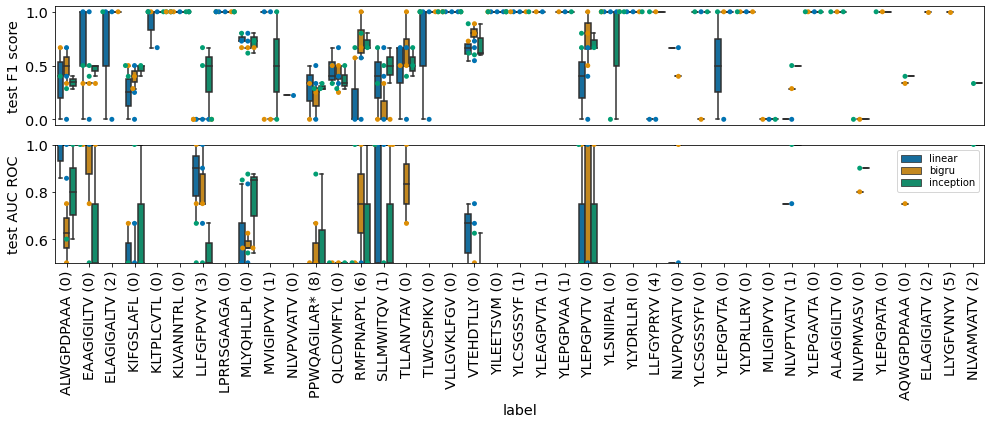

In [120]:
sns.set_palette("colorblind")
fig, axs = container_5a._plot_best_model(
    sns_data=results_tab_s5a,
    x="label",
    hue="model",
    show_partition="test",
    plot_f1=True, 
    plot_fp_only=False, 
    plot_tp_only=False,
    plot_roc_only=False,
    ylim=None,
    xrot=90,
    width_fig=14,
    height_fig=7,
    show_swarm=True
)
plt.tight_layout()
plt.savefig(figir+"supp_5a.pdf")
plt.show()

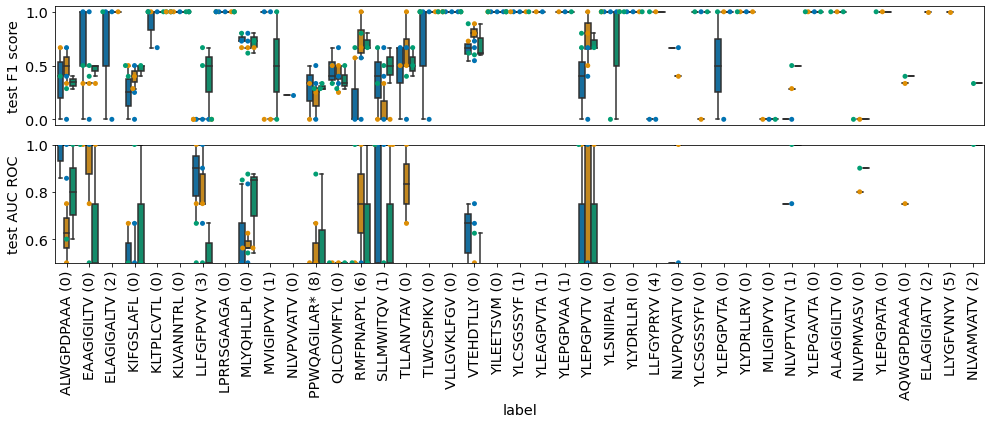

In [121]:
sns.set_palette("colorblind")
fig, axs = container_5a._plot_best_model(
    sns_data=results_tab_s5a,
    x="label",
    hue="model",
    show_partition="test",
    plot_f1=True, 
    plot_fp_only=False, 
    plot_tp_only=False,
    plot_roc_only=False,
    ylim=None,
    xrot=90,
    width_fig=14,
    height_fig=7,
    show_swarm=True
)
axs[1].legend_.remove()
plt.tight_layout()
plt.savefig(figir+"supp_5a_nolegend.pdf")
plt.show()

Scalars performance metrics mentioned in text:

In [93]:
print(results_tab_s5a.groupby(["label", "model"])["auc_test"].mean().groupby(["label"]).max())

label
ALAGIGILTV          NaN
ALWGPDPAAA     0.952381
AQWGPDPAAA     0.750000
EAAGIGILTV     1.000000
ELAGIGALTV          NaN
ELAGIGIATV          NaN
KIFGSLAFL      0.666667
KLTPLCVTL           NaN
KLVANNTRL           NaN
LLFGFPVYV      0.855556
LLFGYPRYV           NaN
LLYGFVNYV           NaN
LPRRSGAAGA          NaN
MLIGIPVYV           NaN
MLYQHLLPL      0.755556
MVIGIPVYV           NaN
NLVAMVATV      1.000000
NLVPMVASV      0.900000
NLVPQVATV      1.000000
NLVPTVATV      1.000000
NLVPVVATV      0.428571
PPWQAGILAR*    0.555556
QLCDVMFYL      0.416667
RMFPNAPYL      0.750000
SLLMWITQV      1.000000
TLLANVTAV      0.833333
TLWCSPIKV           NaN
VLLGVKLFGV          NaN
VTEHDTLLY      0.611111
YILEETSVM           NaN
YLCSGSSYF           NaN
YLCSGSSYFV          NaN
YLEAGPVTA           NaN
YLEPGAVTA           NaN
YLEPGPATA           NaN
YLEPGPVAA           NaN
YLEPGPVTA           NaN
YLEPGPVTV      0.666667
YLSNIIPAL           NaN
YLYDRLLRI           NaN
YLYDRLLRV           NaN
Name: auc_

In [94]:
print(results_tab_s5a.groupby(["label", "model"])["auc_test"].mean().groupby(["label"]).max().mean())

0.7856701940035273


## Supp. Fig. 5b (Test set: unseen antigens from VDJdb)

In [95]:
container_5b = tm.train.SummaryContainer(
    indir=grid_search_dir + "/iedb/", 
    gs_ids=[
        's_bilstm',
        's_bigru',
        's_nettcr',
        's_linear'
    ]
)
container_5b.load_all(data="vdjdb", load_peptide_seqs_by_dataset=True)

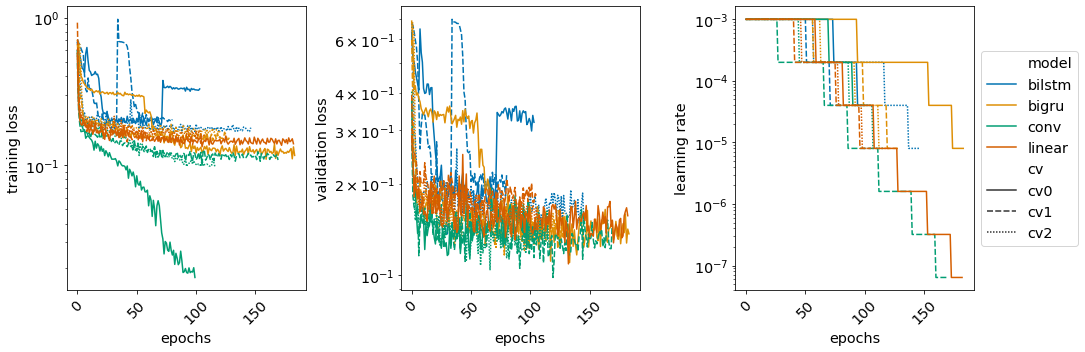

In [96]:
ids = container_5b.choose_best(
    partition="val",
    metric="keras_ce",
    groups_keep=["model"]
)["run"]
container_5b.plot_training_overview(ids=ids)
plt.tight_layout()

In [97]:
results_tab_s5b = container_5b.load_table(
    subset=[]
)
results_tab_s5b = container_5b.reduce_table(
    tab=results_tab_s5b,
    metric="keras_ce",
    partition="val",
    groups_keep=["model"]
)
results_tab_s5b = container_5b.rename_levels(
    tab=results_tab_s5b,
    rename_levels=[]
)
results_tab_s5b = pandas.concat([
    pandas.DataFrame(dict([
        (k, [v[i] for x in range(len(container_5b.peptide_seqs_unique[run]))])
        for k, v in results_tab_s5b.items()
    ] + [
        ("label", container_5b.peptide_seqs_unique[run])
    ] + [
        (k + "_" + show_partition, v.flatten())
        for k, v in container_5b.evaluations_custom[run][show_partition]["local"].items()
    ]))
    for i, run in enumerate(results_tab_s5b["run"].values)
])
# Add label-wise F1 score
for x in ["train", "val", "test"]:
    results_tab_s5b["f1_" + x] = 2*results_tab_s5b["prec_" + x].values * results_tab_s5b["rec_" + x].values /\
        (results_tab_s5b["prec_" + x].values + results_tab_s5b["rec_" + x].values + 1e-10)

In [98]:
# save training labels:
antigens_iedb_iedb = np.sort(np.unique(
    results_tab_s5b.loc[np.isnan(results_tab_s5b["f1_test"].values), "label"].values
))
# remove labels that were not in test set: not included in custom metrics.
results_tab_s5b = results_tab_s5b.loc[~np.isnan(results_tab_s5b["f1_test"].values), :].copy()
antigens_iedb_vdjdb = np.sort(np.unique(results_tab_s5b["label"].values))
# remove empty categories:
results_tab_s5b["label"] = pandas.Categorical(
    results_tab_s5b["label"].astype(str),
    categories=np.sort(np.unique(results_tab_s5b["label"].values))
)

In [99]:
# shorten label names for plotting:
results_tab_s5b["label"] = [
    x if len(x) <= 10 else x[:10]+"*" for x in results_tab_s5b["label"].values
]

In [100]:
# add minimal distance to training data to label names:
antigens_iedb_vdjdb_dist = sort_antigens_by_similarity(
    query_antigens=antigens_iedb_vdjdb,
    reference_antigens=antigens_iedb_iedb
)
results_tab_s5b["label"] = [
    x + " (" + str(antigens_iedb_vdjdb_dist[x]) + ")"
    for x in results_tab_s5b["label"].values
]

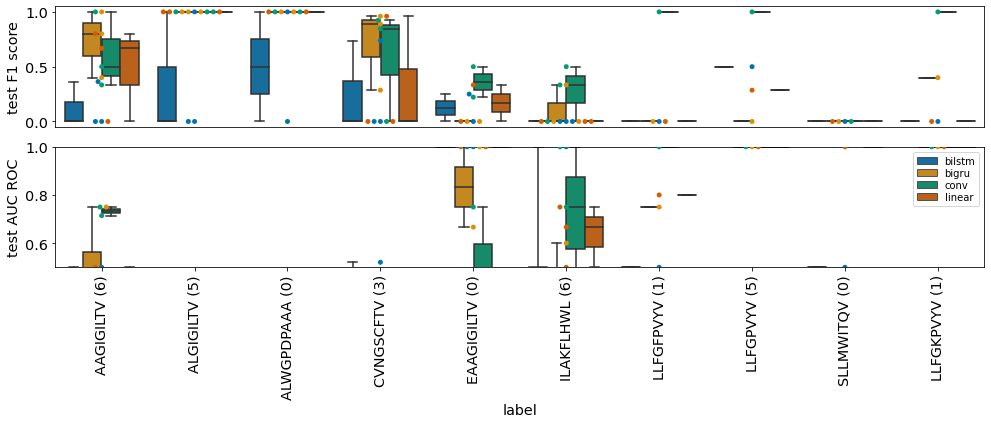

In [101]:
sns.set_palette("colorblind")
fig, axs = container_5b._plot_best_model(
    sns_data=results_tab_s5b,
    x="label",
    hue="model",
    show_partition="test",
    plot_f1=True, 
    plot_fp_only=False, 
    plot_tp_only=False,
    plot_roc_only=False,
    ylim=None,
    xrot=90,
    width_fig=14,
    height_fig=7,
    show_swarm=True
)
plt.tight_layout()
plt.savefig(figir+"supp_5b.pdf")
plt.show()

Remove legend for manuscript panel:

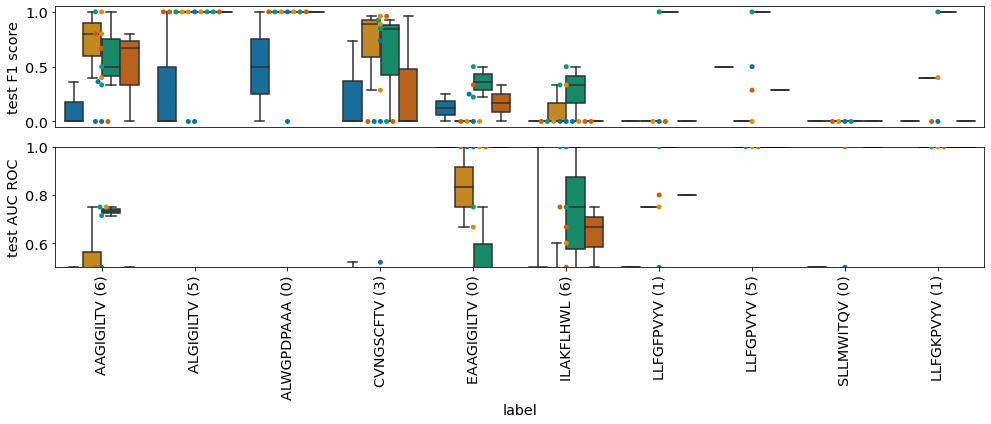

In [102]:
sns.set_palette("colorblind")
fig, axs = container_5b._plot_best_model(
    sns_data=results_tab_s5b,
    x="label",
    hue="model",
    show_partition="test",
    plot_f1=True, 
    plot_fp_only=False, 
    plot_tp_only=False,
    plot_roc_only=False,
    ylim=None,
    xrot=90,
    width_fig=14,
    height_fig=7,
    show_swarm=True
)
axs[1].legend_.remove()
plt.tight_layout()
plt.savefig(figir+"supp_5b_nolegend.pdf")
plt.show()

Scalars performance metrics mentioned in text:

In [103]:
print(results_tab_s5b.groupby(["label", "model"])["auc_test"].mean().groupby(["label"]).max())

label
AAGIGILTV (6)     0.732143
ALGIGILTV (5)          NaN
ALWGPDPAAA (0)         NaN
CVNGSCFTV (3)     0.468750
EAAGIGILTV (0)    1.000000
ILAKFLHWL (6)     0.716667
LLFGFPVYV (1)     1.000000
LLFGKPVYV (1)     1.000000
LLFGPVYV (5)      1.000000
SLLMWITQV (0)     1.000000
Name: auc_test, dtype: float64


In [104]:
print(results_tab_s5b.groupby(["label", "model"])["auc_test"].mean().groupby(["label"]).max().mean())

0.8646949404761906


##  Supp. Fig. 5c (Test set: unseen antigens from single-cell data)

In [105]:
container_5c = tm.train.SummaryContainer(
    indir=grid_search_dir + "/iedb/", 
    gs_ids=[
        's_bilstm',
        's_bigru',
        's_nettcr',
        's_linear'
    ]
)
container_5c.load_all(data="10x_cd8", load_peptide_seqs_by_dataset=True)

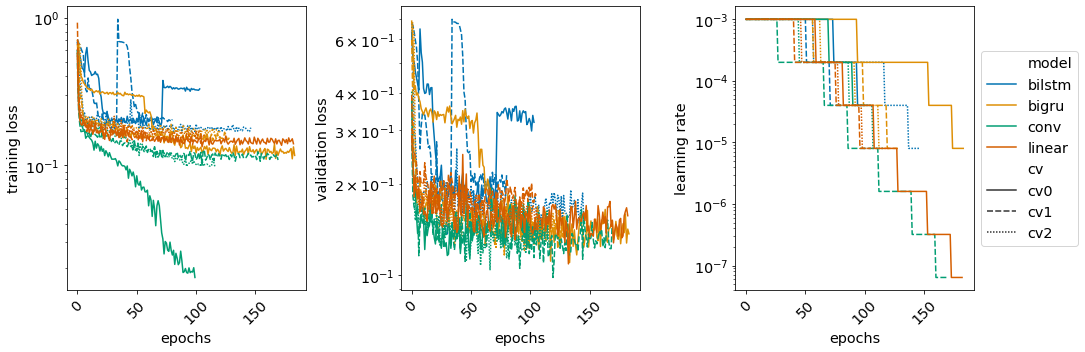

In [106]:
ids = container_5c.choose_best(
    partition="val",
    metric="keras_ce",
    groups_keep=["model"]
)["run"]
container_5c.plot_training_overview(ids=ids)
plt.tight_layout()

In [107]:
show_partition = "test"
results_tab_s5c = container_5c.load_table(
    subset=[]
)
results_tab_s5c = container_5c.reduce_table(
    tab=results_tab_s5c,
    metric="keras_ce",
    partition="val",
    groups_keep=["model"]
)
container_5c.load_y(ids=results_tab_s5c["run"].values)
results_tab_s5c = pandas.concat([
    pandas.DataFrame(dict([
        (k, [v[i] for x in range(len(container_5c.peptide_seqs_unique[run]))])
        for k, v in results_tab_s5c.items()
    ] + [
        ("label", container_5c.peptide_seqs_unique[run])
    ] + [
        (k + "_" + show_partition, v.flatten())
        for k, v in container_5c.evaluations_custom[run][show_partition]["local"].items()
    ]))
    for i, run in enumerate(results_tab_s5c["run"].values)
])
# Add label-wise F1 score
for x in ["train", "val", "test"]:
    results_tab_s5c["f1_" + x] = 2*results_tab_s5c["prec_" + x].values * results_tab_s5c["rec_" + x].values /\
        (results_tab_s5c["prec_" + x].values + results_tab_s5c["rec_" + x].values + 1e-10)

In [108]:
# save training labels:
antigens_iedb_iedb = np.sort(np.unique(
    results_tab_s5c.loc[np.isnan(results_tab_s5c["f1_test"].values), "label"].values
))
# remove labels that were not in test set: not included in custom metrics.
results_tab_s5c = results_tab_s5c.loc[~np.isnan(results_tab_s5c["f1_test"].values), :].copy()
antigens_iedb_10x = np.sort(np.unique(results_tab_s5c["label"].values))
# remove empty categories:
results_tab_s5c["label"] = pandas.Categorical(
    results_tab_s5c["label"].astype(str),
    categories=np.sort(np.unique(results_tab_s5c["label"].values))
)

In [109]:
# add minimal distance to training data to label names:
antigens_iedb_10x_dist = sort_antigens_by_similarity(
    query_antigens=antigens_iedb_10x,
    reference_antigens=antigens_iedb_iedb
)
results_tab_s5c["label"] = [
    x + " (" + str(antigens_iedb_10x_dist[x]) + ")"
    for x in results_tab_s5c["label"].values
]

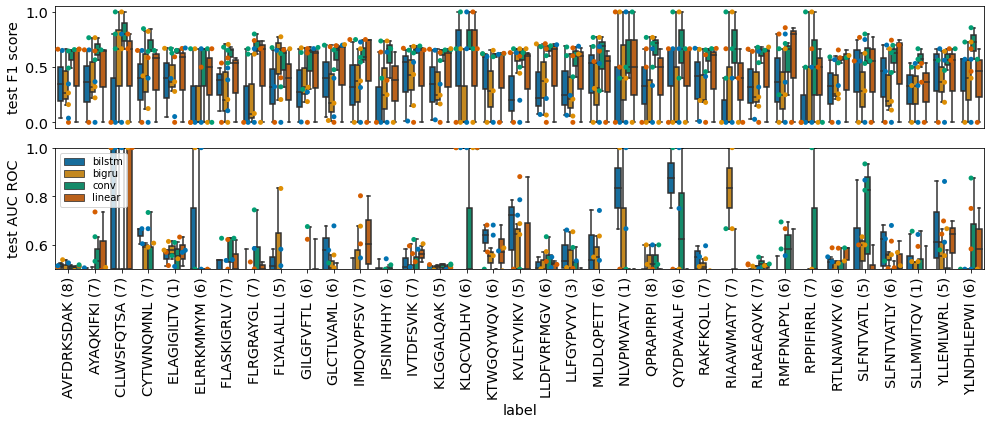

In [110]:
sns.set_palette("colorblind")
fig, axs = container_5c._plot_best_model(
    sns_data=results_tab_s5c,
    x="label",
    hue="model",
    show_partition="test",
    plot_f1=True, 
    plot_fp_only=False, 
    plot_tp_only=False,
    plot_roc_only=False,
    ylim=None,
    xrot=90,
    width_fig=14,
    height_fig=7,
    show_swarm=True
)
plt.tight_layout()
plt.savefig(figir+"supp_5c.pdf")
plt.show()

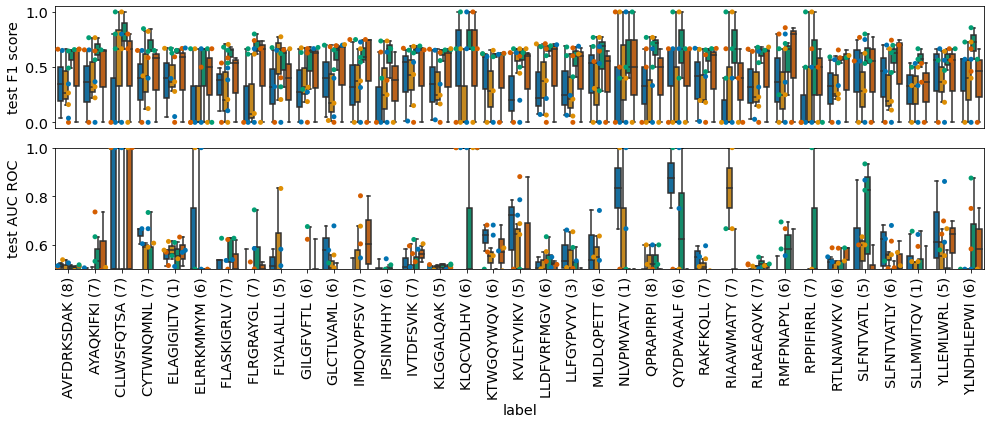

In [111]:
sns.set_palette("colorblind")
fig, axs = container_5c._plot_best_model(
    sns_data=results_tab_s5c,
    x="label",
    hue="model",
    show_partition="test",
    plot_f1=True, 
    plot_fp_only=False, 
    plot_tp_only=False,
    plot_roc_only=False,
    ylim=None,
    xrot=90,
    width_fig=14,
    height_fig=7,
    show_swarm=True
)
axs[1].legend_.remove()
plt.tight_layout()
plt.savefig(figir+"supp_5c_nolegend.pdf")
plt.show()

Scalars performance metrics mentioned in text:

In [112]:
print(results_tab_s5c.groupby(["label", "model"])["auc_test"].mean().groupby(["label"]).max())

label
AVFDRKSDAK (8)    0.515026
AYAQKIFKI (7)     0.557108
CLLWSFQTSA (7)    0.666667
CYTWNQMNL (7)     0.646032
ELAGIGILTV (1)    0.578484
ELRRKMMYM (6)     0.500000
FLASKIGRLV (7)    0.562675
FLRGRAYGL (7)     0.500879
FLYALALLL (5)     0.540389
GILGFVFTL (6)     0.419260
GLCTLVAML (6)     0.543130
IMDQVPFSV (7)     0.613812
IPSINVHHY (6)     0.466667
IVTDFSVIK (7)     0.563495
KLGGALQAK (5)     0.510161
KLQCVDLHV (6)     1.000000
KTWGQYWQV (6)     0.632160
KVLEYVIKV (5)     0.648479
LLDFVRFMGV (6)    0.503975
LLFGYPVYV (3)     0.556012
MLDLQPETT (6)     0.526010
NLVPMVATV (1)     0.833333
QPRAPIRPI (8)     0.506667
QYDPVAALF (6)     0.875000
RAKFKQLL (7)      0.533341
RIAAWMATY (7)     0.833333
RLRAEAQVK (7)     0.511514
RMFPNAPYL (6)     0.518519
RPPIFIRRL (7)     0.500000
RTLNAWVKV (6)     0.555714
SLFNTVATL (5)     0.686111
SLFNTVATLY (6)    0.567937
SLLMWITQV (1)     0.526786
YLLEMLWRL (5)     0.652116
YLNDHLEPWI (6)    0.555556
Name: auc_test, dtype: float64


In [113]:
print(results_tab_s5c.groupby(["label", "model"])["auc_test"].mean().groupby(["label"]).max().mean())

0.5916099450323624
